<a href="https://colab.research.google.com/github/n1xd/5900/blob/main/CIT5900_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Prep


In [ ]:
import pandas as pd

# Define column priorities
column_mapping = {
    'author': ['author', 'pi', 'researchers', 'project_pi', 'projectpi'],
    'year': ['year', 'projectendyear'],
    'title': ['title', 'projecttitle'],
    'doi': ['doi']
}

dataframes = []

for i in range(1, 9):
    file_name = f"group{i}.csv"
    try:
        df = pd.read_csv(file_name)
        lower_columns = {col.lower(): col for col in df.columns}
        new_df = pd.DataFrame()

        for target_col, source_options in column_mapping.items():
            collected = []

            for source_col in source_options:
                lower_col = source_col.lower()
                if lower_col in lower_columns:
                    actual_col = lower_columns[lower_col]
                    # Extract and clean values
                    cleaned = (
                        df[actual_col]
                        .astype(str)
                        .str.split(r'[;,]')
                        .apply(lambda parts: [part.strip() for part in parts])
                    )
                    collected.append(cleaned)

            if collected:
                # Combine all matched columns row-wise and take the first non-null value per row
                new_df[target_col] = pd.DataFrame(collected).T.apply(
                    lambda row: next((item for sublist in row if isinstance(sublist, list) for item in sublist if item and item.lower() != 'nan'), pd.NA),
                    axis=1
                )
            else:
                new_df[target_col] = pd.NA

        # Filter out rows where any of the required columns are empty/NA
        complete_records = new_df.dropna(subset=column_mapping.keys())

        if not complete_records.empty:
            dataframes.append(complete_records)

    except FileNotFoundError:
        print(f"Warning: {file_name} not found. Skipping.")

# Combine and save
if dataframes:
    combined_df = pd.concat(dataframes, ignore_index=True)
    combined_df.to_csv("combined_complete_records.csv", index=False)
    print(f"Saved {len(combined_df)} complete records.")
else:
    print("No complete records found.")

Saved 14133 complete records.


# APIs

OPENALEX API

In [ ]:
import pandas as pd
import requests

# Step 1: Load the Excel file from GitHub
with open("combined_complete_records.csv", "r") as file:
    df = pd.read_csv(file)

# Step 3: Extract unique doi
doi_unique = df['doi'].dropna().unique()

print("First few doi:", doi_unique[:10])

First few doi: ['https://doi.org/10.30875/25189808-2022-9'
 'https://doi.org/10.1016/j.chaos.2023.113567'
 'https://doi.org/10.48550/arxiv.1509.02574'
 'https://doi.org/10.1016/j.eeh.2019.101304'
 'https://doi.org/10.48550/arxiv.2204.04253'
 'https://doi.org/10.48550/arxiv.2302.02767'
 'https://doi.org/10.17509/jaset.v11i2.17922'
 'https://doi.org/10.1007/s13370-019-00674-3'
 'https://doi.org/10.48550/arxiv.2405.08595'
 'https://doi.org/10.2139/ssrn.5118227']


In [ ]:
import pandas as pd
import requests
import time
import os

# Load the CSV file
df = pd.read_csv("combined_complete_records.csv")

# Extract unique DOIs
doi_unique = df['doi'].dropna().unique()

# File to save results
output_file = "all_doi_openalex_lookup.csv"

# Track progress
buffer = []
save_every = 500  # Save after this many entries
existing_dois = set()

# Check if file exists and load existing entries (resume support)
if os.path.exists(output_file):
    existing_df = pd.read_csv(output_file)
    existing_dois = set(existing_df['doi'].str.strip().str.lower())
    print(f"Resuming... {len(existing_dois)} DOIs already processed.")
else:
    with open(output_file, "w") as f:
        f.write("doi,openalex_id,status\n")  # Write header

# Loop through all DOIs
for i, doi in enumerate(doi_unique, start=1):
    doi = doi.strip().lower()
    if doi in existing_dois:
        continue  # Skip already processed

    doi_encoded = requests.utils.quote(doi, safe='')
    url = f"https://api.openalex.org/works/https://doi.org/{doi_encoded}"

    try:
        response = requests.get(url)
        time.sleep(1)  # Respect rate limit

        if response.status_code == 200:
            data = response.json()
            openalex_id = data.get('id', '')
            status = "Found"
        elif response.status_code == 404:
            openalex_id = ""
            status = "Not Found"
        else:
            openalex_id = ""
            status = f"Error {response.status_code}"

    except Exception as e:
        openalex_id = ""
        status = f"Exception: {str(e)}"

    buffer.append({'doi': doi, 'openalex_id': openalex_id, 'status': status})

    # Save every 500 entries
    if len(buffer) >= save_every:
        pd.DataFrame(buffer).to_csv(output_file, mode='a', header=False, index=False)
        print(f"✅ Saved {len(buffer)} new records (up to DOI {i})")
        buffer = []  # Clear buffer

    if i % 500 == 0:
      print(f"Processed {i} DOIs...")

# Final save
if buffer:
    pd.DataFrame(buffer).to_csv(output_file, mode='a', header=False, index=False)
    print(f"✅ Final save: {len(buffer)} remaining records")

# Print summary
total_processed = len(existing_dois) + len(doi_unique) - len(existing_dois)
print(f"\n🚀 Finished processing {total_processed} DOIs.")


✅ Saved 500 new records (up to DOI 500)
Processed 500 DOIs...
✅ Saved 500 new records (up to DOI 1000)
Processed 1000 DOIs...
✅ Saved 500 new records (up to DOI 1500)
Processed 1500 DOIs...
✅ Saved 500 new records (up to DOI 2000)
Processed 2000 DOIs...
✅ Saved 500 new records (up to DOI 2500)
Processed 2500 DOIs...
✅ Saved 500 new records (up to DOI 3000)
Processed 3000 DOIs...
✅ Saved 500 new records (up to DOI 3500)
Processed 3500 DOIs...


In [ ]:
import pandas as pd
import requests
import time
import re
import os

# Load matched DOIs and OpenAlex IDs
df_dois = pd.read_csv("all_doi_openalex_lookup.csv")
df_dois = df_dois[df_dois['status'] == 'Found'].reset_index(drop=True)

# Safe getter for nested dictionary/list fields
def safe_get(obj, keys, default=None):
    for key in keys:
        if isinstance(obj, dict) and key in obj:
            obj = obj[key]
        elif isinstance(obj, list) and isinstance(key, int) and len(obj) > key:
            obj = obj[key]
        else:
            return default
    return obj

# Map OpenAlex types to desired abbreviations
output_type_map = {
    "book-chapter": "BC", "blog": "BG", "dissertation": "DI", "dataset": "DS",
    "journal-article": "JA", "mimeo": "MI", "mastersthesis": "MT",
    "report": "RE", "software": "SW", "technical-report": "TN", "working-paper": "WP"
}

# FSRDC-related keywords
fsrdc_keywords = [
    "Census Bureau", "FSRDC", "Federal Statistical Research Data Center",
    "restricted microdata", "IRS", "BEA", "confidentiality review",
    "Michigan RDC", "Texas RDC", "Boston RDC",
    "Annual Survey of Manufactures", "Census of Construction Industries",
    "Census of Finance, Insurance, and Real Estate"
]

# Initialize
enriched_results = []
fsrdc_count = 0
batch_size = 500
output_file = "fsrdc_papers_openalex.csv"
progress_interval = 500  # Print progress every 500 records

# Remove old file if exists
if os.path.exists(output_file):
    os.remove(output_file)

for i, row in df_dois.iterrows():
    # Progress tracking
    if i % progress_interval == 0:
        print(f"ℹ️ Processed {i} records so far...")

    doi = row['doi']
    openalex_id = row['openalex_id']

    if openalex_id.startswith("https://openalex.org/"):
        work_id = openalex_id.split("/")[-1]
        api_url = f"https://api.openalex.org/works/{work_id}"
    else:
        continue  # Skip invalid IDs

    try:
        response = requests.get(api_url)
        time.sleep(1)
        data = response.json()

        if not data or not isinstance(data, dict):
            continue

        # Extract metadata
        title = data.get("title", "")

        # Skip if not FSRDC-related
        if not any(keyword.lower() in title.lower() for keyword in fsrdc_keywords):
            continue

        publication_year = data.get("publication_year", "")
        publication_date = data.get("publication_date", "")
        openalex_type = data.get("type", "").lower()
        work_type = output_type_map.get(openalex_type, openalex_type.upper())

        venue_name = safe_get(data, ["host_venue", "display_name"], "")
        if not venue_name:
            venue_name = safe_get(data, ["primary_location", "source", "display_name"], "Unknown")

        biblio = data.get("biblio", {})
        volume = biblio.get("volume", "")
        issue = biblio.get("issue", "")
        pages = f"{biblio.get('first_page', '')}-{biblio.get('last_page', '')}".strip("-")

        # Detect RDC from institutions
        project_rdc = "Unknown"
        authorships = data.get("authorships", [])
        for auth in authorships:
            institutions = auth.get("institutions", [])
            for inst in institutions:
                name = inst.get("display_name", "")
                if name and (any(keyword.lower() in name.lower() for keyword in fsrdc_keywords) or
                            re.search(r'\bRDC\b', name, re.IGNORECASE)):
                    project_rdc = name
                    break
            if project_rdc != "Unknown":
                break

        project_pi = safe_get(data, ["authorships", 0, "author", "display_name"], "Unknown")

        # Extract project title from FSRDC-related title
        match = re.search(r'(FSRDC:?\s*)?([\w\s-]+?(?=using|based|analysis|study|research|$))',
                         title, re.IGNORECASE)
        project_title = match.group(2).strip() if match else title[:100]


        # Build record
        record = {
            "ProjID": i + 1,
            "ProjectStatus": "Completed",
            "ProjectTitle": project_title,
            "ProjectRDC": project_rdc,
            "ProjectYearStarted": publication_year,
            "ProjectYearEnded": publication_year,
            "ProjectPI": project_pi,
            "OutputTitle": title,
            "OutputBiblio": f"{venue_name}, Vol {volume}, Iss {issue}, pp. {pages}",
            "OutputType": work_type,
            "OutputStatus": "PB",
            "OutputVenue": venue_name,
            "OutputYear": publication_year,
            "OutputMonth": publication_date[5:7] if publication_date else "",
            "OutputVolume": volume,
            "OutputNumber": issue,
            "OutputPages": pages
        }

        enriched_results.append(record)
        fsrdc_count += 1

        # Batch saving
        if (i + 1) % batch_size == 0 or (i + 1) == len(df_dois):
            pd.DataFrame(enriched_results).to_csv(
                output_file,
                mode='a',
                header=not os.path.exists(output_file),
                index=False
            )
            print(f"💾 Saved batch of {len(enriched_results)} FSRDC papers (Total found: {fsrdc_count})")
            enriched_results = []

    except Exception as e:
        print(f"⚠️ Error processing {doi}: {str(e)}")
        continue

print(f"\n✅ Completed. Found and saved {fsrdc_count} FSRDC-related papers to {output_file}")

ℹ️ Processed 0 records so far...
ℹ️ Processed 500 records so far...
ℹ️ Processed 1000 records so far...
⚠️ Error processing 10.1023/a:1023705401078: 'NoneType' object has no attribute 'lower'
💾 Saved batch of 97 FSRDC papers (Total found: 97)
ℹ️ Processed 1500 records so far...
ℹ️ Processed 2000 records so far...
ℹ️ Processed 2500 records so far...
⚠️ Error processing 10.7752/jpes.2019.s1017: 'NoneType' object has no attribute 'lower'
ℹ️ Processed 3000 records so far...
ℹ️ Processed 3500 records so far...
ℹ️ Processed 4000 records so far...
ℹ️ Processed 4500 records so far...
ℹ️ Processed 5000 records so far...
ℹ️ Processed 5500 records so far...
ℹ️ Processed 6000 records so far...
ℹ️ Processed 6500 records so far...
ℹ️ Processed 7000 records so far...
ℹ️ Processed 7500 records so far...
💾 Saved batch of 182 FSRDC papers (Total found: 279)
ℹ️ Processed 8000 records so far...
ℹ️ Processed 8500 records so far...
ℹ️ Processed 9000 records so far...
⚠️ Error processing 10.1002/soej.v85.4: 

In [ ]:


# Load matched DOIs and OpenAlex IDs
df_dois = pd.read_csv("all_doi_openalex_lookup.csv")
df_dois = df_dois[df_dois['status'] == 'Found'].reset_index(drop=True)

# Configuration - MODIFY THESE VALUES
start_from_record = 13000  # Start from where you left off
output_file = "fsrdc_papers_openalex.csv"
existing_fsrdc_count = 628  # Current count from your output

# Check if output file exists to determine if we need headers
file_exists = os.path.exists(output_file)

# [Keep all your existing functions and constants...]

# Initialize with existing count
fsrdc_count = existing_fsrdc_count
enriched_results = []
batch_size = 500
progress_interval = 500

# Process only remaining records
for i in range(start_from_record, len(df_dois)):
    row = df_dois.iloc[i]

    # Progress tracking
    if i % progress_interval == 0:
        print(f"ℹ️ Processed {i} records so far...")

    doi = row['doi']
    openalex_id = row['openalex_id']

    if openalex_id.startswith("https://openalex.org/"):
        work_id = openalex_id.split("/")[-1]
        api_url = f"https://api.openalex.org/works/{work_id}"
    else:
        continue

    try:
        response = requests.get(api_url)
        time.sleep(1)
        data = response.json()

        if not data or not isinstance(data, dict):
            continue

        # [Keep all your existing processing logic...]

        enriched_results.append(record)
        fsrdc_count += 1

        # Batch saving
        if (i + 1) % batch_size == 0 or (i + 1) == len(df_dois):
            pd.DataFrame(enriched_results).to_csv(
                output_file,
                mode='a',
                header=not file_exists,
                index=False
            )
            print(f"💾 Saved batch of {len(enriched_results)} FSRDC papers (Total found: {fsrdc_count})")
            enriched_results = []
            file_exists = True  # After first write, headers exist

    except Exception as e:
        print(f"⚠️ Error processing {doi}: {str(e)}")
        continue

print(f"\n✅ Completed. Found and saved {fsrdc_count} FSRDC-related papers to {output_file}")

ℹ️ Processed 13000 records so far...
💾 Saved batch of 49 FSRDC papers (Total found: 677)

✅ Completed. Found and saved 677 FSRDC-related papers to fsrdc_papers_openalex.csv


NIH API


In [ ]:
import pandas as pd
import requests

# Step 1: Load the Excel file from GitHub
with open("combined_complete_records.csv", "r") as file:
    df = pd.read_csv(file)

# Step 3: Extract unique doi
doi_unique = df['doi'].dropna().unique()

print("First few doi:", doi_unique[:10])

First few doi: ['https://doi.org/10.30875/25189808-2022-9'
 'https://doi.org/10.1016/j.chaos.2023.113567'
 'https://doi.org/10.48550/arxiv.1509.02574'
 'https://doi.org/10.1016/j.eeh.2019.101304'
 'https://doi.org/10.48550/arxiv.2204.04253'
 'https://doi.org/10.48550/arxiv.2302.02767'
 'https://doi.org/10.17509/jaset.v11i2.17922'
 'https://doi.org/10.1007/s13370-019-00674-3'
 'https://doi.org/10.48550/arxiv.2405.08595'
 'https://doi.org/10.2139/ssrn.5118227']


In [ ]:
import pandas as pd
import requests
import time
import os
from xml.etree import ElementTree

# NIH E-utilities API endpoint
ncbi_esearch_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"

# Output file
output_file = "doi_pubmed_lookup.csv"
save_every = 500

# Load full list
df = pd.read_csv("combined_complete_records.csv")
doi_list = df['doi'].dropna().unique()

# Load already processed DOIs (if resuming)
existing_dois = set()
if os.path.exists(output_file):
    existing_df = pd.read_csv(output_file)
    existing_dois = set(existing_df['doi'].str.strip().str.lower())
    print(f"🔁 Resuming from previous run: {len(existing_dois)} DOIs already processed.")
else:
    with open(output_file, "w") as f:
        f.write("doi,status,pmid\n")  # Write header

# Prepare buffer for incremental saving
buffer = []

# Start processing
for i, doi in enumerate(doi_list, start=1):
    doi = doi.strip().lower()
    if doi in existing_dois:
        continue  # Skip already processed

    params = {
        "db": "pubmed",
        "term": doi,
        "retmode": "xml"
    }

    try:
        response = requests.get(ncbi_esearch_url, params=params)
        time.sleep(0.4)

        if response.status_code == 200:
            root = ElementTree.fromstring(response.content)
            id_list = root.find("IdList")
            pmids = id_list.findall("Id") if id_list is not None else []

            if len(pmids) > 0:
                buffer.append({"doi": doi, "status": "Found", "pmid": pmids[0].text})
            else:
                buffer.append({"doi": doi, "status": "Not Found", "pmid": None})
        else:
            buffer.append({"doi": doi, "status": f"Error {response.status_code}", "pmid": None})

    except Exception as e:
        buffer.append({"doi": doi, "status": "Exception", "pmid": None})

    # Save every 500 entries
    if len(buffer) >= save_every:
        pd.DataFrame(buffer).to_csv(output_file, mode='a', header=False, index=False)
        print(f"💾 Saved {len(buffer)} records at DOI {i}")
        buffer = []

    if i % 500 == 0:
      print(f"Processed {i} DOIs...")


# Final save
if buffer:
    pd.DataFrame(buffer).to_csv(output_file, mode='a', header=False, index=False)
    print(f"✅ Final save of {len(buffer)} remaining records.")

# Summary
df_final = pd.read_csv(output_file)
total = len(df_final)
matched = len(df_final[df_final["status"] == "Found"])
print(f"\n🎯 PubMed search complete.")
print(f"   🔍 Total DOIs checked: {total}")
print(f"   ✅ Total matched in PubMed: {matched}")
print(f"   ❌ Not found: {total - matched}")


💾 Saved 500 records at DOI 500
Processed 500 DOIs...
💾 Saved 500 records at DOI 1000
Processed 1000 DOIs...
💾 Saved 500 records at DOI 1500
Processed 1500 DOIs...
💾 Saved 500 records at DOI 2000
Processed 2000 DOIs...
💾 Saved 500 records at DOI 2500
Processed 2500 DOIs...
💾 Saved 500 records at DOI 3000
Processed 3000 DOIs...
💾 Saved 500 records at DOI 3500
Processed 3500 DOIs...
💾 Saved 500 records at DOI 4000
Processed 4000 DOIs...


In [ ]:
#extraction of pmcid
import pandas as pd
import requests
import time
from xml.etree import ElementTree
from tqdm import tqdm  # for progress bars

# Configure
API_DELAY = 0.34  # NIH rate limit (3 requests/second)
PMC_SEARCH_URL = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
OUTPUT_FILE = "pmc_availability_results_with_doi.csv"

# Load your data
df = pd.read_csv("combined_complete_records.csv")
print(f"Loaded {len(df)} records from your file")

def clean_author(author_str):
    """Extract first author's last name from author string"""
    if pd.isna(author_str):
        return ""
    first_author = author_str.split(";")[0].split(",")[0].strip()
    return first_author.split()[0] if first_author else ""

def check_by_doi(doi):
    """Check PMC availability by DOI (most reliable method)"""
    if pd.isna(doi) or not str(doi).strip():
        return False, None

    clean_doi = str(doi).strip()
    params = {
        "db": "pmc",
        "term": f'{clean_doi}[DOI]',
        "retmode": "xml",
        "retmax": 1
    }

    try:
        response = requests.get(PMC_SEARCH_URL, params=params)
        time.sleep(API_DELAY)

        if response.status_code == 200:
            root = ElementTree.fromstring(response.content)
            count = int(root.findtext(".//Count") or "0")
            if count > 0:
                pmcid = root.findtext(".//IdList/Id")
                return True, pmcid
    except Exception as e:
        print(f"Error checking DOI {clean_doi[:30]}...: {str(e)}")

    return False, None

def check_by_title_author(title, author):
    """Fallback method: Check by title and author"""
    query = f'("{title}"[Title]) AND {author}[Author]'

    params = {
        "db": "pmc",
        "term": query,
        "retmode": "xml",
        "retmax": 1
    }

    try:
        response = requests.get(PMC_SEARCH_URL, params=params)
        time.sleep(API_DELAY)

        if response.status_code == 200:
            root = ElementTree.fromstring(response.content)
            count = int(root.findtext(".//Count") or "0")
            if count > 0:
                pmcid = root.findtext(".//IdList/Id")
                return True, pmcid
    except Exception as e:
        print(f"Error checking {title[:30]}...: {str(e)}")

    return False, None

# Prepare results
results = []

# Process records with progress bar
for idx, row in tqdm(df.iterrows(), total=len(df)):
    title = str(row['title'])[:500]  # truncate very long titles
    author = clean_author(str(row.get('author', '')))
    doi = row.get('doi', '')  # Assuming your DOI column is named 'doi'

    # Initialize result dict
    result = {
        'ProjID': idx,
        'Title': title,
        'Author': author,
        'DOI': doi,
        'In_PMC': False,
        'PMCID': None,
        'Method': None,
        'Reason': None
    }

    # First try DOI lookup if available
    if doi and str(doi).strip() and str(doi).strip().lower() != 'nan':
        found, pmcid = check_by_doi(doi)
        if found:
            result.update({
                'In_PMC': True,
                'PMCID': pmcid,
                'Method': 'DOI',
                'Reason': 'Found by DOI'
            })
            results.append(result)
            continue

    # Fall back to title/author if no DOI or DOI lookup failed
    if title and author:
        found, pmcid = check_by_title_author(title, author)
        if found:
            result.update({
                'In_PMC': True,
                'PMCID': pmcid,
                'Method': 'Title/Author',
                'Reason': 'Found by title/author'
            })
        else:
            result.update({
                'Reason': 'Not found in PMC'
            })
    else:
        result.update({
            'Reason': 'Missing title or author'
        })

    results.append(result)

# Save enhanced results
df_results = pd.DataFrame(results)
df_results.to_csv(OUTPUT_FILE, index=False)
print(f"Saved results to {OUTPUT_FILE}")

# Print summary
print("\n=== Summary of findings ===")
print(f"Total records processed: {len(df_results)}")
print(f"Records found in PMC: {len(df_results[df_results['In_PMC']])}")
print("\nBreakdown by discovery method:")
print(df_results[df_results['In_PMC']]['Method'].value_counts())
print("\nReasons for not finding records:")
print(df_results[~df_results['In_PMC']]['Reason'].value_counts())

Loaded 14133 records from your file


 74%|███████▍  | 10475/14133 [2:00:57<39:09,  1.56it/s]

In [ ]:
import pandas as pd
import requests
import time
from xml.etree import ElementTree
from tqdm import tqdm

# Load previous results
df_availability = pd.read_csv("pmc_availability_results_with_doi.csv")
pmc_papers = df_availability[df_availability['In_PMC']].copy()
print(f"Found {len(pmc_papers)} papers in PMC to process")

Found 5118 papers in PMC to process


In [ ]:
import pandas as pd
import requests
import time
import re
from xml.etree import ElementTree
from tqdm import tqdm

# Keywords for FSRDC-related filtering
fsrdc_keywords = [
    "Census Bureau", "FSRDC", "Federal Statistical Research Data Center",
    "restricted microdata", "IRS", "BEA", "confidentiality review",
    "Michigan RDC", "Texas RDC", "Boston RDC",
    "Annual Survey of Manufactures", "Census of Construction Industries",
    "Census of Finance, Insurance, and Real Estate"
]

# Output type mapping
output_type_map = {
    "book-chapter": "BC", "blog": "BG", "dissertation": "DI", "dataset": "DS",
    "journal-article": "JA", "mimeo": "MI", "mastersthesis": "MT",
    "report": "RE", "software": "SW", "technical-report": "TN", "working-paper": "WP"
}

def is_fsrdc_related(text):
    if not isinstance(text, str):
        return False
    return any(keyword.lower() in text.lower() for keyword in fsrdc_keywords)

def fetch_pmc_metadata(pmcid):
    try:
        params = {"db": "pmc", "id": pmcid, "retmode": "xml"}
        response = requests.get("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi", params=params)
        time.sleep(0.34)
        return response.text if response.status_code == 200 else None
    except Exception:
        return None

def parse_pmc_metadata(xml_content):
    try:
        root = ElementTree.fromstring(xml_content)
        article = root.find('.//article')
        if article is None:
            return None

        title = " ".join([t.text for t in article.findall('.//article-title') if t.text])
        abstract = " ".join([t.text for t in article.findall('.//abstract//p') if t.text])

        if not (is_fsrdc_related(title) or is_fsrdc_related(abstract)):
            return None

        first_author = "Unknown"
        institution = "Unknown"

        for contrib in article.findall('.//contrib[@contrib-type="author"]'):
            name = contrib.find('.//name')
            if name is not None:
               surname = name.findtext('surname') or ""
               given_names = name.findtext('given-names') or ""
               full_name = f"{given_names} {surname}".strip()
               if full_name:
                  first_author = full_name

            aff = contrib.find('.//aff')
            if aff is not None and aff.text:
               institution = aff.text.strip()

            break  # Only process the first author



        journal_title = article.findtext('.//journal-title-group/journal-title')
        pub_date = article.find('.//pub-date[@date-type="pub"]')
        year = pub_date.findtext('year') if pub_date is not None else ''
        month = pub_date.findtext('month') if pub_date is not None else ''
        volume = article.findtext('.//volume') or ''
        issue = article.findtext('.//issue') or ''
        fpage = article.findtext('.//fpage')
        lpage = article.findtext('.//lpage')
        pages = f"{fpage}-{lpage}" if fpage and lpage else fpage or ''

        article_type = article.get('article-type', '').lower()

        return {
            'Title': title,
            'Year': year,
            'Month': month,
            'Volume': volume,
            'Issue': issue,
            'Pages': pages,
            'ArticleType': article_type,
            'Journal': journal_title,
            'ProjectPI': first_author,
            'Institution': institution
        }

    except Exception:
        return None

def process_nih_records(pmc_ids, output_file="fsrdc_papers_pmc.csv"):
    results = []
    total_saved = 0
    save_interval = 500

    for i, pmcid in enumerate(tqdm(pmc_ids, desc="Processing PMC records"), start=1):
        xml_content = fetch_pmc_metadata(pmcid)
        if not xml_content:
            continue

        metadata = parse_pmc_metadata(xml_content)
        if metadata:
            row = metadata
            output_type = output_type_map.get(row.get('ArticleType', '').lower(), 'OT')

            journal = str(row.get('Journal', '')).strip()
            volume = str(row.get('Volume', '')).strip()
            issue = str(row.get('Issue', '')).strip()
            pages = str(row.get('Pages', '')).strip()

            if all([journal, volume, issue, pages]):
                full_citation = f"{journal}, Vol {volume}, Iss {issue}, pp. {pages}"
            else:
                full_citation = "None"

            results.append({
                'ProjID': total_saved + len(results) + 1,
                'ProjectStatus': 'Completed',
                'ProjectTitle': row.get('Title', '') if "fsrdc" in row.get('Title', '').lower() else "FSRDC Project",
                'ProjectRDC': row.get('Institution', 'Unknown'),
                'ProjectYearStarted': row.get('Year', 'Unknown'),
                'ProjectYearEnded': row.get('Year', 'Unknown'),
                'ProjectPI': row.get('ProjectPI', 'Unknown'),
                'OutputTitle': row.get('Title', 'Unknown'),
                'OutputBiblio': full_citation,
                'OutputType': output_type,
                'OutputStatus': 'PB',
                'OutputVenue': journal,
                'OutputYear': row.get('Year', 'Unknown'),
                'OutputMonth': str(row.get('Month', 'Unknown'))[:2],
                'OutputVolume': volume,
                'OutputNumber': issue,
                'OutputPages': pages
            })

        # Print processing update every 100 records
        if i % 100 == 0:
            print(f"🔄 Processed {i} PMC records...")

        # Save every 500 results to the same file
        if len(results) >= save_interval:
            df = pd.DataFrame(results)
            mode = 'a' if total_saved > 0 else 'w'
            header = total_saved == 0
            df.to_csv(output_file, mode=mode, index=False, header=header)
            print(f"💾 Saved {len(df)} more records to {output_file}")
            total_saved += len(df)
            results.clear()

    # Save remaining entries
    if results:
        df = pd.DataFrame(results)
        mode = 'a' if total_saved > 0 else 'w'
        header = total_saved == 0
        df.to_csv(output_file, mode=mode, index=False, header=header)
        print(f"💾 Saved final {len(df)} records to {output_file}")
        total_saved += len(df)

    print(f"✅ Total FSRDC-related papers found: {total_saved}")
    return total_saved


# Example run:
pmc_ids = pd.read_csv("pmc_availability_results_with_doi.csv")['PMCID'].dropna().tolist()
process_nih_records(pmc_ids)


Processing PMC records:   2%|▏         | 100/5118 [01:16<1:07:31,  1.24it/s]

🔄 Processed 100 PMC records...


Processing PMC records:   4%|▍         | 200/5118 [02:36<1:04:09,  1.28it/s]

🔄 Processed 200 PMC records...


Processing PMC records:   6%|▌         | 300/5118 [03:54<1:01:33,  1.30it/s]

🔄 Processed 300 PMC records...


Processing PMC records:   8%|▊         | 400/5118 [05:11<1:01:31,  1.28it/s]

🔄 Processed 400 PMC records...


Processing PMC records:  10%|▉         | 500/5118 [06:31<55:21,  1.39it/s]

🔄 Processed 500 PMC records...


Processing PMC records:  12%|█▏        | 600/5118 [07:46<54:28,  1.38it/s]

🔄 Processed 600 PMC records...


Processing PMC records:  14%|█▎        | 700/5118 [09:16<1:02:09,  1.18it/s]

🔄 Processed 700 PMC records...


Processing PMC records:  16%|█▌        | 800/5118 [10:34<56:04,  1.28it/s]

🔄 Processed 800 PMC records...


Processing PMC records:  18%|█▊        | 900/5118 [11:55<54:02,  1.30it/s]

🔄 Processed 900 PMC records...


Processing PMC records:  20%|█▉        | 1000/5118 [13:14<54:34,  1.26it/s]

🔄 Processed 1000 PMC records...


Processing PMC records:  21%|██▏       | 1100/5118 [14:32<47:46,  1.40it/s]

🔄 Processed 1100 PMC records...


Processing PMC records:  23%|██▎       | 1200/5118 [15:53<50:41,  1.29it/s]

🔄 Processed 1200 PMC records...


Processing PMC records:  25%|██▌       | 1300/5118 [17:10<48:37,  1.31it/s]

🔄 Processed 1300 PMC records...


Processing PMC records:  25%|██▌       | 1305/5118 [17:15<54:45,  1.16it/s]

💾 Saved 500 more records to fsrdc_papers_pmc.csv


Processing PMC records:  27%|██▋       | 1400/5118 [18:30<49:21,  1.26it/s]

🔄 Processed 1400 PMC records...


Processing PMC records:  29%|██▉       | 1500/5118 [19:46<45:33,  1.32it/s]

🔄 Processed 1500 PMC records...


Processing PMC records:  31%|███▏      | 1600/5118 [21:04<45:42,  1.28it/s]

🔄 Processed 1600 PMC records...


Processing PMC records:  33%|███▎      | 1700/5118 [22:20<43:09,  1.32it/s]

🔄 Processed 1700 PMC records...


Processing PMC records:  35%|███▌      | 1800/5118 [23:34<42:37,  1.30it/s]

🔄 Processed 1800 PMC records...


Processing PMC records:  37%|███▋      | 1900/5118 [24:50<40:57,  1.31it/s]

🔄 Processed 1900 PMC records...


Processing PMC records:  39%|███▉      | 2000/5118 [26:04<37:12,  1.40it/s]

🔄 Processed 2000 PMC records...


Processing PMC records:  41%|████      | 2100/5118 [27:23<41:24,  1.21it/s]

🔄 Processed 2100 PMC records...


Processing PMC records:  43%|████▎     | 2200/5118 [28:42<38:12,  1.27it/s]

🔄 Processed 2200 PMC records...


Processing PMC records:  45%|████▍     | 2300/5118 [29:57<34:14,  1.37it/s]

🔄 Processed 2300 PMC records...


Processing PMC records:  47%|████▋     | 2400/5118 [31:12<33:48,  1.34it/s]

🔄 Processed 2400 PMC records...


Processing PMC records:  48%|████▊     | 2445/5118 [31:47<34:43,  1.28it/s]

💾 Saved 500 more records to fsrdc_papers_pmc.csv


Processing PMC records:  49%|████▉     | 2500/5118 [32:29<34:51,  1.25it/s]

🔄 Processed 2500 PMC records...


Processing PMC records:  51%|█████     | 2600/5118 [33:48<33:50,  1.24it/s]

🔄 Processed 2600 PMC records...


Processing PMC records:  53%|█████▎    | 2700/5118 [35:04<32:12,  1.25it/s]

🔄 Processed 2700 PMC records...


Processing PMC records:  55%|█████▍    | 2800/5118 [36:20<28:59,  1.33it/s]

🔄 Processed 2800 PMC records...


Processing PMC records:  57%|█████▋    | 2900/5118 [37:36<26:51,  1.38it/s]

🔄 Processed 2900 PMC records...


Processing PMC records:  59%|█████▊    | 3000/5118 [38:52<25:52,  1.36it/s]

🔄 Processed 3000 PMC records...


Processing PMC records:  61%|██████    | 3100/5118 [40:08<24:08,  1.39it/s]

🔄 Processed 3100 PMC records...


Processing PMC records:  63%|██████▎   | 3200/5118 [41:24<30:37,  1.04it/s]

🔄 Processed 3200 PMC records...


Processing PMC records:  64%|██████▍   | 3300/5118 [42:43<27:45,  1.09it/s]

🔄 Processed 3300 PMC records...


Processing PMC records:  66%|██████▋   | 3400/5118 [43:58<22:05,  1.30it/s]

🔄 Processed 3400 PMC records...


Processing PMC records:  68%|██████▊   | 3500/5118 [45:13<19:25,  1.39it/s]

🔄 Processed 3500 PMC records...


Processing PMC records:  70%|███████   | 3600/5118 [46:27<18:16,  1.38it/s]

🔄 Processed 3600 PMC records...


Processing PMC records:  72%|███████▏  | 3700/5118 [47:41<18:36,  1.27it/s]

🔄 Processed 3700 PMC records...


Processing PMC records:  74%|███████▍  | 3800/5118 [48:57<16:07,  1.36it/s]

🔄 Processed 3800 PMC records...


Processing PMC records:  75%|███████▍  | 3826/5118 [49:16<16:22,  1.31it/s]

💾 Saved 500 more records to fsrdc_papers_pmc.csv


Processing PMC records:  76%|███████▌  | 3900/5118 [50:13<15:05,  1.35it/s]

🔄 Processed 3900 PMC records...


Processing PMC records:  78%|███████▊  | 4000/5118 [51:27<13:25,  1.39it/s]

🔄 Processed 4000 PMC records...


Processing PMC records:  80%|████████  | 4100/5118 [52:44<12:08,  1.40it/s]

🔄 Processed 4100 PMC records...


Processing PMC records:  82%|████████▏ | 4200/5118 [54:00<11:12,  1.37it/s]

🔄 Processed 4200 PMC records...


Processing PMC records:  84%|████████▍ | 4300/5118 [55:15<10:31,  1.30it/s]

🔄 Processed 4300 PMC records...


Processing PMC records:  86%|████████▌ | 4400/5118 [56:30<09:25,  1.27it/s]

🔄 Processed 4400 PMC records...


Processing PMC records:  88%|████████▊ | 4500/5118 [57:45<07:51,  1.31it/s]

🔄 Processed 4500 PMC records...


Processing PMC records:  90%|████████▉ | 4600/5118 [59:04<07:51,  1.10it/s]

🔄 Processed 4600 PMC records...


Processing PMC records:  92%|█████████▏| 4700/5118 [1:00:21<05:17,  1.32it/s]

🔄 Processed 4700 PMC records...


Processing PMC records:  94%|█████████▍| 4800/5118 [1:01:38<04:00,  1.32it/s]

🔄 Processed 4800 PMC records...


Processing PMC records:  96%|█████████▌| 4900/5118 [1:02:54<02:41,  1.35it/s]

🔄 Processed 4900 PMC records...


Processing PMC records:  98%|█████████▊| 5000/5118 [1:04:10<01:27,  1.35it/s]

🔄 Processed 5000 PMC records...


Processing PMC records:  99%|█████████▉| 5087/5118 [1:05:17<00:24,  1.28it/s]

💾 Saved 500 more records to fsrdc_papers_pmc.csv


Processing PMC records: 100%|█████████▉| 5100/5118 [1:05:26<00:12,  1.41it/s]

🔄 Processed 5100 PMC records...


Processing PMC records: 100%|██████████| 5118/5118 [1:05:39<00:00,  1.30it/s]

💾 Saved final 19 records to fsrdc_papers_pmc.csv
✅ Total FSRDC-related papers found: 2019


2019

Unittesting

In [ ]:
def is_fsrdc_related(text):
    keywords = [
        "Census Bureau", "FSRDC", "Federal Statistical Research Data Center",
        "restricted microdata", "IRS", "BEA", "confidentiality review",
        "Michigan RDC", "Texas RDC", "Boston RDC",
        "Annual Survey of Manufactures", "Census of Construction Industries",
        "Census of Finance, Insurance, and Real Estate"
    ]
    if not isinstance(text, str):
        return False
    return any(keyword.lower() in text.lower() for keyword in keywords)

def parse_pmc_metadata(xml_content):
    import xml.etree.ElementTree as ET
    try:
        root = ET.fromstring(xml_content)
        article = root.find('.//article')
        if article is None:
            return None

        title = " ".join([t.text for t in article.findall('.//article-title') if t.text])
        abstract = " ".join([t.text for t in article.findall('.//abstract//p') if t.text])

        if not (is_fsrdc_related(title) or is_fsrdc_related(abstract)):
            return None

        return {"Title": title, "Abstract": abstract}
    except Exception:
        return None


In [ ]:
import unittest

class TestFSRDCExtractor(unittest.TestCase):

    def test_is_fsrdc_related_true(self):
        text = "This study uses data from the Census Bureau and FSRDC."
        self.assertTrue(is_fsrdc_related(text))

    def test_is_fsrdc_related_false(self):
        text = "This study is about marine biology and ocean currents."
        self.assertFalse(is_fsrdc_related(text))

    def test_parse_pmc_metadata_invalid_xml(self):
        bad_xml = "<notvalid><unclosed>"
        result = parse_pmc_metadata(bad_xml)
        self.assertIsNone(result)

    def test_parse_pmc_metadata_not_fsrdc_related(self):
        xml = """<?xml version="1.0"?>
            <pmc-articleset>
                <article>
                    <front>
                        <article-meta>
                            <title-group>
                                <article-title>Marine Biology Advances</article-title>
                            </title-group>
                            <abstract><p>This study explores oceanography.</p></abstract>
                        </article-meta>
                    </front>
                </article>
            </pmc-articleset>
        """
        result = parse_pmc_metadata(xml)
        self.assertIsNone(result)

# Run the tests and display results
unittest.TextTestRunner(verbosity=2).run(unittest.TestLoader().loadTestsFromTestCase(TestFSRDCExtractor))


test_is_fsrdc_related_false (__main__.TestFSRDCExtractor.test_is_fsrdc_related_false) ... ok
test_is_fsrdc_related_true (__main__.TestFSRDCExtractor.test_is_fsrdc_related_true) ... ok
test_parse_pmc_metadata_invalid_xml (__main__.TestFSRDCExtractor.test_parse_pmc_metadata_invalid_xml) ... ok
test_parse_pmc_metadata_not_fsrdc_related (__main__.TestFSRDCExtractor.test_parse_pmc_metadata_not_fsrdc_related) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.018s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

ORCID API

In [ ]:
import pandas as pd
import requests
import re
from time import sleep, time
from datetime import datetime, timedelta
import logging
import sys

# Disable all logging
logging.basicConfig(level=logging.CRITICAL)

def safe_api_call(url, headers=None, params=None):
    try:
        response = requests.get(url, headers=headers, params=params, timeout=10)
        response.raise_for_status()
        return response.json()
    except:
        return None

def process_pi_record(pi_data, index):
    try:
        pi_name = pi_data['author']
        title = pi_data['title']
        year = pi_data['year']

        # ORCID search
        orcid_result = safe_api_call(
            "https://pub.orcid.org/v3.0/search/",
            headers={'Accept': 'application/json'},
            params={'q': f'given-names:{pi_name.split()[0]} AND family-name:{pi_name.split()[-1]}'}
        )

        if not orcid_result or not orcid_result.get('result'):
            return None

        orcid_id = orcid_result['result'][0]['orcid-identifier']['path']
        sleep(1.2)

        # Get ORCID record
        record = safe_api_call(f"https://pub.orcid.org/v3.0/{orcid_id}/record",
                             headers={'Accept': 'application/json'})

        if not record:
            return None

        # Process works
        works = record.get('activities-summary', {}).get('works', {}).get('group', [])
        for group in works:
            for work_summary in group.get('work-summary', []):
                work = safe_api_call(f"https://pub.orcid.org/v3.0/{orcid_id}/work/{work_summary.get('put-code')}",
                                   headers={'Accept': 'application/json'})
                if work and work.get('title'):
                    return {
                        'ProjID': f"PROJ_{index:05d}",
                        'ProjectPI': pi_name,
                        'ProjectTitle': title,
                        'OutputTitle': work['title'].get('title', {}).get('value', ''),
                        'DOI': next((id['external-id-value'] for id in work.get('external-ids', {}).get('external-id', [])
                                    if id.get('external-id-type') == 'doi'), ''),
                        'OutputYear': work.get('publication-date', {}).get('year', {}).get('value', '')
                    }
        return None
    except:
        return None

def print_progress(current, total, start_time, valid_count):
    elapsed = time() - start_time
    percent = (current / total) * 100
    eta = (elapsed / current) * (total - current) if current > 0 else 0

    sys.stdout.write(
        f'\rProcessed: {current}/{total} ({percent:.1f}%) | '
        f'Valid: {valid_count} | '
        f'ETA: {str(timedelta(seconds=int(eta)))}'
    )
    sys.stdout.flush()

def enrich_data(input_csv, output_csv):
    df = pd.read_csv(input_csv)
    total = len(df)
    results = []
    start_time = time()

    print(f"Starting ORCID enrichment for {total} PIs...\n")

    for idx, row in df.iterrows():
        result = process_pi_record(row, idx + 1)
        if result:
            results.append(result)

        if (idx + 1) % 100 == 0 or (idx + 1) == total:
            print_progress(idx + 1, total, start_time, len(results))

    if results:
        pd.DataFrame(results).to_csv(output_csv, index=False)
        print(f"\n\nCompleted! Saved {len(results)} enriched records to {output_csv}")
    else:
        print("\n\nNo valid records found")

if __name__ == '__main__':
    enrich_data('combined_complete_records.csv', 'enriched_research_outputs.csv')

Starting ORCID enrichment for 14133 PIs...

Processed: 14133/14133 (100.0%) | Valid: 2811 | ETA: 0:00:00

Completed! Saved 2811 enriched records to enriched_research_outputs.csv


In [ ]:
import pandas as pd
import requests
import re
from time import sleep, time
from datetime import datetime, timedelta
import logging
import sys
import json

# Configure logging to show only critical errors
logging.basicConfig(level=logging.CRITICAL)

def safe_api_call(url, headers=None, params=None):
    """Make API calls with error handling"""
    try:
        response = requests.get(url, headers=headers, params=params, timeout=15)
        response.raise_for_status()
        return response.json()
    except Exception as e:
        return None

def extract_doi_info(doi):
    """Extract additional metadata from DOI using CrossRef API"""
    if not doi:
        return {}

    try:
        response = requests.get(f"https://api.crossref.org/works/{doi}", timeout=10)
        if response.status_code == 200:
            data = response.json().get('message', {})
            return {
                'OutputVenue': data.get('container-title', [''])[0],
                'OutputVolume': data.get('volume', ''),
                'OutputNumber': data.get('issue', ''),
                'OutputPage': f"{data.get('page', '')}",
                'OutputMonth': data.get('published-print', {}).get('date-parts', [[0, 0]])[0][1] if len(data.get('published-print', {}).get('date-parts', [[0]])[0]) > 1 else '',
                'OutputBiblio': format_biblio(data)
            }
    except:
        pass
    return {}

def format_biblio(data):
    """Format bibliographic information from CrossRef data"""
    try:
        authors = ", ".join([f"{a.get('family', '')}, {a.get('given', '')}" for a in data.get('author', [])])
        title = data.get('title', [''])[0]
        journal = data.get('container-title', [''])[0]
        volume = data.get('volume', '')
        issue = data.get('issue', '')
        page = data.get('page', '')
        year = data.get('published', {}).get('date-parts', [[0]])[0][0] if 'published' in data else ''

        biblio = f"{authors}. {title}."
        if journal:
            biblio += f" {journal}"
            if volume:
                biblio += f" {volume}"
                if issue:
                    biblio += f"({issue})"
            if page:
                biblio += f", {page}"
        if year:
            biblio += f" ({year})"
        return biblio
    except:
        return ""

def determine_output_type(work):
    """Determine output type from ORCID work data"""
    if not work:
        return "Unknown"

    type_map = {
        'journal-article': 'Journal Article',
        'book': 'Book',
        'book-chapter': 'Book Chapter',
        'conference-paper': 'Conference Paper',
        'dataset': 'Dataset',
        'report': 'Report',
        'patent': 'Patent',
        'dissertation': 'Dissertation',
        'review': 'Review',
        'preprint': 'Preprint'
    }

    work_type = work.get('type', '').lower()
    return type_map.get(work_type, work_type.replace('-', ' ').title() if work_type else 'Publication')

def process_pi_record(pi_data, index):
    """Process PI record and enrich with ORCID data"""
    try:
        if not pi_data:
            return None

        # Try different column names that might contain PI name
        pi_name = None
        for key in ['author', 'ProjectPI', 'PI', 'project_pi', 'pi_name', 'name']:
            if key in pi_data and pi_data[key]:
                pi_name = pi_data[key]
                break

        # If PI name still not found, log and return
        if not pi_name or not isinstance(pi_name, str) or len(pi_name.split()) < 2:
            print(f"Debug - Missing or invalid PI name for record {index}. Keys: {list(pi_data.keys())}")
            return None

        # Try different column names for project title
        project_title = None
        for key in ['title', 'ProjectTitle', 'project_title']:
            if key in pi_data and pi_data[key]:
                project_title = pi_data[key]
                break

        project_year = pi_data.get('year', '')

        # Generate a project ID - either use existing or create new
        proj_id = pi_data.get('ProjID', '') or f"PROJ_{index:05d}"

        # Debug print
        print(f"Debug - Processing PI: {pi_name}, Title: {project_title[:30]}...")

        # ORCID search - try different name formats
        orcid_result = None
        name_parts = pi_name.split()

        # Try first with standard format
        search_query = f'given-names:{name_parts[0]} AND family-name:{name_parts[-1]}'
        orcid_result = safe_api_call(
            "https://pub.orcid.org/v3.0/search/",
            headers={'Accept': 'application/json'},
            params={'q': search_query}
        )

        # If that fails, try with just the last name
        if not orcid_result or not orcid_result.get('result'):
            search_query = f'family-name:{name_parts[-1]}'
            orcid_result = safe_api_call(
                "https://pub.orcid.org/v3.0/search/",
                headers={'Accept': 'application/json'},
                params={'q': search_query}
            )

        if not orcid_result or not orcid_result.get('result'):
            print(f"Debug - No ORCID found for {pi_name}")
            return None

        orcid_id = orcid_result['result'][0]['orcid-identifier']['path']
        sleep(1.2)  # Respect rate limits

        # Get ORCID record
        record = safe_api_call(f"https://pub.orcid.org/v3.0/{orcid_id}/record",
                             headers={'Accept': 'application/json'})

        if not record:
            return None

        # Extract employment history for project dates
        employments = record.get('activities-summary', {}).get('employments', {}).get('employment-summary', [])
        project_start = next((emp.get('start-date', {}).get('year', {}).get('value') for emp in employments if emp.get('start-date')), '')
        project_end = next((emp.get('end-date', {}).get('year', {}).get('value') for emp in employments if emp.get('end-date')), 'Ongoing')

        # Extract organization/institution (RDC)
        project_rdc = next((emp.get('organization', {}).get('name') for emp in employments), '')

        # Process works to find outputs
        works = record.get('activities-summary', {}).get('works', {}).get('group', [])
        results = []

        for group in works[:min(5, len(works))]:  # Limit to max 5 works per PI
            for work_summary in group.get('work-summary', [])[:1]:  # Take first work from each group
                work = safe_api_call(f"https://pub.orcid.org/v3.0/{orcid_id}/work/{work_summary.get('put-code')}",
                                  headers={'Accept': 'application/json'})

                if work and work.get('title'):
                    # Extract DOI if available
                    doi = next((id['external-id-value'] for id in work.get('external-ids', {}).get('external-id', [])
                              if id.get('external-id-type') == 'doi'), '')

                    # Get publication year and month
                    pub_date = work.get('publication-date', {})
                    year = pub_date.get('year', {}).get('value', '')
                    month = pub_date.get('month', {}).get('value', '')

                    # Get additional metadata from DOI
                    doi_metadata = extract_doi_info(doi) if doi else {}

                    # Determine output type and status
                    output_type = determine_output_type(work)
                    output_status = "Published" if year else "In Progress"

                    result = {
                        'ProjID': proj_id,
                        'ProjectStatus': "Completed" if project_end and project_end != 'Ongoing' else "Active",
                        'ProjectTitle': project_title,
                        'ProjectRDC': project_rdc,
                        'ProjectYearStarted': project_start or '',
                        'ProjectYearEnded': project_end or '',
                        'ProjectPI': pi_name,
                        'OutputTitle': work['title'].get('title', {}).get('value', ''),
                        'OutputBiblio': doi_metadata.get('OutputBiblio', ''),
                        'OutputType': output_type,
                        'OutputStatus': output_status,
                        'OutputVenue': doi_metadata.get('OutputVenue', ''),
                        'OutputYear': year,
                        'OutputMonth': doi_metadata.get('OutputMonth', month),
                        'OutputVolume': doi_metadata.get('OutputVolume', ''),
                        'OutputNumber': doi_metadata.get('OutputNumber', ''),
                        'OutputPage': doi_metadata.get('OutputPage', ''),
                        'DOI': doi
                    }
                    results.append(result)

        return results[0] if results else None
    except Exception as e:
        print(f"Error processing record: {e}")
        return None

def print_progress(current, total, start_time, valid_count):
    """Print progress information"""
    elapsed = time() - start_time
    percent = (current / total) * 100
    eta = (elapsed / current) * (total - current) if current > 0 else 0

    sys.stdout.write(
        f'\rProcessed: {current}/{total} ({percent:.1f}%) | '
        f'Valid: {valid_count} | '
        f'ETA: {str(timedelta(seconds=int(eta)))}'
    )
    sys.stdout.flush()

def enrich_data(input_csv, output_csv):
    """Main function to enrich data from CSV using ORCID API"""
    try:
        # Read input data and print column names to debug
        df = pd.read_csv(input_csv)
        print(f"Input CSV columns: {df.columns.tolist()}")
        print(f"First row sample: {df.iloc[0].to_dict()}")

        # If the CSV is using the enriched columns already, preserve data
        output_data = []
        if 'ProjectPI' in df.columns and 'ProjectTitle' in df.columns:
            # The file already has some structure we should preserve
            print("Using existing ProjectPI and ProjectTitle columns...")
            # Create a copy to avoid modifying the original
            output_df = df.copy()
        else:
            # We need to create a new dataframe
            output_df = pd.DataFrame()

        total = len(df)
        results = []
        start_time = time()

        print(f"Starting ORCID enrichment for {total} PIs...\n")

        # Process a small sample first to debug
        sample_size = min(5, total)
        print(f"Processing sample of {sample_size} records first...")

        for idx, row in df.head(sample_size).iterrows():
            result = process_pi_record(row.to_dict(), idx + 1)
            if result:
                results.append(result)
                print(f"Success! Found ORCID data for {row.get('ProjectPI', row.get('author', 'Unknown'))}")
            else:
                print(f"Failed to find ORCID data for {row.get('ProjectPI', row.get('author', 'Unknown'))}")

        # If sample worked, process the rest
        if results:
            print(f"Sample processing successful. Processing remaining records...")
            for idx, row in df.iloc[sample_size:].iterrows():
                result = process_pi_record(row.to_dict(), idx + 1)
                if result:
                    results.append(result)

                if (idx + 1) % 10 == 0 or (idx + 1) == total:
                    print_progress(idx + 1, total, start_time, len(results))
        else:
            # If no results from sample, try to generate placeholder data
            print("No results from ORCID API. Generating placeholder data from input file...")
            for idx, row in df.iterrows():
                row_dict = row.to_dict()

                # Create basic record from existing data
                result = {
                    'ProjID': row_dict.get('ProjID', f"PROJ_{idx+1:05d}"),
                    'ProjectStatus': row_dict.get('ProjectStatus', 'Unknown'),
                    'ProjectTitle': row_dict.get('ProjectTitle', row_dict.get('title', 'Unknown')),
                    'ProjectRDC': row_dict.get('ProjectRDC', 'Unknown'),
                    'ProjectYearStarted': row_dict.get('ProjectYearStarted', ''),
                    'ProjectYearEnded': row_dict.get('ProjectYearEnded', ''),
                    'ProjectPI': row_dict.get('ProjectPI', row_dict.get('author', 'Unknown')),
                    'OutputTitle': row_dict.get('OutputTitle', row_dict.get('title', 'Unknown')),
                    'OutputBiblio': row_dict.get('OutputBiblio', ''),
                    'OutputType': row_dict.get('OutputType', 'Publication'),
                    'OutputStatus': row_dict.get('OutputStatus', 'Unknown'),
                    'OutputVenue': row_dict.get('OutputVenue', ''),
                    'OutputYear': row_dict.get('OutputYear', row_dict.get('year', '')),
                    'OutputMonth': row_dict.get('OutputMonth', ''),
                    'OutputVolume': row_dict.get('OutputVolume', ''),
                    'OutputNumber': row_dict.get('OutputNumber', ''),
                    'OutputPage': row_dict.get('OutputPage', ''),
                    'DOI': row_dict.get('DOI', '')
                }
                results.append(result)

                if (idx + 1) % 100 == 0 or (idx + 1) == total:
                    print_progress(idx + 1, total, start_time, len(results))

        if results:
            output_df = pd.DataFrame(results)

            # Ensure all required columns are present
            required_columns = [
                'ProjID', 'ProjectStatus', 'ProjectTitle', 'ProjectRDC', 'ProjectYearStarted',
                'ProjectYearEnded', 'ProjectPI', 'OutputTitle', 'OutputBiblio', 'OutputType',
                'OutputStatus', 'OutputVenue', 'OutputYear', 'OutputMonth', 'OutputVolume',
                'OutputNumber', 'OutputPage', 'DOI'
            ]

            for col in required_columns:
                if col not in output_df.columns:
                    output_df[col] = ''

            # Reorder columns to match required order
            output_df = output_df[required_columns]

            # Save to CSV
            output_df.to_csv(output_csv, index=False)
            print(f"\n\nCompleted! Saved {len(results)} enriched records to {output_csv}")
        else:
            print("\n\nNo valid records found")
    except Exception as e:
        print(f"Error in data enrichment: {e}")
        import traceback
        traceback.print_exc()

def main():
    # First try to read the existing enriched file to preserve data
    try:
        print("Checking if enriched_research_outputs.csv exists...")
        existing_df = pd.read_csv('enriched_research_outputs.csv')
        print(f"Found existing file with {len(existing_df)} records and columns: {existing_df.columns.tolist()}")

        print("Would you like to use the existing enriched file as input? (y/n)")
        use_existing = input().lower().strip() == 'y'

        if use_existing:
            input_file = 'enriched_research_outputs.csv'
            output_file = 'enriched_research_outputs_updated.csv'
        else:
            input_file = 'combined_complete_records.csv'
            output_file = 'enriched_research_outputs.csv'
    except:
        print("No existing enriched file found or error reading it.")
        input_file = 'combined_complete_records.csv'
        output_file = 'enriched_research_outputs.csv'

    # Ask user to confirm the column mapping
    print(f"\nReading from: {input_file}")
    print(f"Writing to: {output_file}")
    print("\nPress Enter to continue, or Ctrl+C to cancel...")
    input()

    enrich_data(input_file, output_file)

if __name__ == '__main__':
    main()

Checking if enriched_research_outputs.csv exists...
Found existing file with 2811 records and columns: ['ProjID', 'ProjectPI', 'ProjectTitle', 'OutputTitle', 'DOI', 'OutputYear']
Would you like to use the existing enriched file as input? (y/n)
y

Reading from: enriched_research_outputs.csv
Writing to: enriched_research_outputs_updated.csv

Press Enter to continue, or Ctrl+C to cancel...

Input CSV columns: ['ProjID', 'ProjectPI', 'ProjectTitle', 'OutputTitle', 'DOI', 'OutputYear']
First row sample: {'ProjID': 'PROJ_00010', 'ProjectPI': 'Jhih-shyang Shih', 'ProjectTitle': 'Emission impossible: Balancing Environmental Concerns and Inflation', 'OutputTitle': 'Modeling Ecological Constraints on a CO2 Pipeline Network', 'DOI': '10.1021/acs.est.3c01721', 'OutputYear': 2023}
Using existing ProjectPI and ProjectTitle columns...
Starting ORCID enrichment for 2811 PIs...

Processing sample of 5 records first...
Debug - Processing PI: Jhih-shyang Shih, Title: Emission impossible: Balancing...
Deb

In [ ]:
import pandas as pd
import requests
import time
import re

def get_orcid_works(orcid_id):
    headers = {"Accept": "application/json"}
    url = f"https://pub.orcid.org/v3.0/{orcid_id}/works"
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        return response.json().get("group", [])
    return []

def get_work_details(orcid_id, put_code):
    headers = {"Accept": "application/json"}
    url = f"https://pub.orcid.org/v3.0/{orcid_id}/work/{put_code}"
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        return response.json()
    return {}

def match_doi(work, target_doi):
    for ext_id in work.get("external-ids", {}).get("external-id", []):
        if ext_id.get("external-id-type", "").lower() == "doi":
            doi = ext_id.get("external-id-value", "").lower()
            if doi == target_doi.lower():
                return True
    return False

def extract_volume_issue_page(citation):
    match = re.search(r'(\d+)\((\d+)\),\s*(\d+-\d+)', citation)
    if match:
        return match.groups()
    return '', '', ''

def enrich_missing_fields(row):
    if pd.notna(row['OutputVenue']) and pd.notna(row['OutputVolume']):
        return row  # Already enriched

    orcid_id = row['ORCID ID']
    doi = row['DOI']
    if pd.isna(orcid_id) or pd.isna(doi):
        return row

    try:
        works = get_orcid_works(orcid_id)
        for group in works:
            for summary in group.get("work-summary", []):
                put_code = summary.get("put-code")
                if not put_code:
                    continue

                work = get_work_details(orcid_id, put_code)
                if match_doi(work, doi):
                    row['OutputVenue'] = work.get('journal-title', {}).get('value', row['OutputVenue'])

                    citation = work.get('citation', {}).get('citation-value', '')
                    volume, number, page = extract_volume_issue_page(citation)
                    row['OutputVolume'] = volume or row['OutputVolume']
                    row['OutputNumber'] = number or row['OutputNumber']
                    row['OutputPage'] = page or row['OutputPage']
                    return row
                time.sleep(0.1)
    except Exception as e:
        print(f"Error processing {orcid_id}: {e}")
    return row

def main():
    df_outputs = pd.read_csv('enriched_research_outputs_updated.csv')
    df_orcids = pd.read_csv('pi_orcid_ids.csv')

    # Merge ORCID IDs into the output dataset
    df = df_outputs.merge(df_orcids, left_on='ProjectPI', right_on='PI Name', how='left')
    df['ORCID ID'] = df['ORCID ID'].fillna('')

    print("Enriching records with missing metadata from ORCID...")
    df = df.apply(enrich_missing_fields, axis=1)

    df.to_csv('enriched_research_outputs_full.csv', index=False)
    print("Saved enriched results to enriched_research_outputs_full.csv")

if __name__ == "__main__":
    main()


Enriching records with missing metadata from ORCID...
Saved enriched results to enriched_research_outputs_full.csv


In [ ]:
import pandas as pd
import requests
import time
import re

def get_work_details_by_doi(orcid_id, target_doi):
    headers = {"Accept": "application/json"}
    base_url = f"https://pub.orcid.org/v3.0/{orcid_id}/works"
    response = requests.get(base_url, headers=headers)
    if response.status_code != 200:
        return {}

    works = response.json().get("group", [])
    for group in works:
        for summary in group.get("work-summary", []):
            put_code = summary.get("put-code")
            ext_ids = summary.get("external-ids", {}).get("external-id", [])
            for ext in ext_ids:
                if ext.get("external-id-type", "").lower() == "doi" and ext.get("external-id-value", "").lower() == target_doi.lower():
                    # Found matching work; fetch full metadata
                    detail_url = f"https://pub.orcid.org/v3.0/{orcid_id}/work/{put_code}"
                    detail_response = requests.get(detail_url, headers=headers)
                    if detail_response.status_code == 200:
                        return detail_response.json()
    return {}

def extract_metadata_from_citation(citation_text):
    # Example: "Environmental Science & Technology 2023, 57 (15), 5746-5753"
    volume, number, page = '', '', ''
    match = re.search(r'(\d{4})[,\s]*(\d+)\s*\((\d+)\)\s*,\s*([\d\-]+)', citation_text)
    if match:
        _, volume, number, page = match.groups()
    return volume, number, page

def enrich_row(row):
    if pd.isna(row['ORCID ID']) or pd.isna(row['DOI']):
        return row

    orcid_id = row['ORCID ID'].strip()
    doi = row['DOI'].strip()

    try:
        work = get_work_details_by_doi(orcid_id, doi)
        if not work:
            return row

        # Month
        month = work.get("publication-date", {}).get("month", {}).get("value")
        if pd.isna(row['OutputMonth']) and month:
            row['OutputMonth'] = month

        # Citation
        citation = work.get("citation", {}).get("citation-value", "")
        if citation:
            vol, num, page = extract_metadata_from_citation(citation)
            if pd.isna(row['OutputVolume']) and vol:
                row['OutputVolume'] = vol
            if pd.isna(row['OutputNumber']) and num:
                row['OutputNumber'] = num
            if pd.isna(row['OutputPage']) and page:
                row['OutputPage'] = page

    except Exception as e:
        print(f"Error processing ORCID {orcid_id}: {e}")

    time.sleep(0.2)  # Respect ORCID rate limits
    return row

def main():
    df = pd.read_csv("enriched_research_outputs_full.csv")

    # Only process rows where these fields are missing
    mask = df['OutputVolume'].isna() | df['OutputMonth'].isna() | df['OutputNumber'].isna() | df['OutputPage'].isna()
    df.loc[mask] = df.loc[mask].apply(enrich_row, axis=1)

    df.to_csv("enriched_research_outputs_orcid_enriched.csv", index=False)
    print("Metadata enrichment complete.")

if __name__ == "__main__":
    main()


Metadata enrichment complete.


In [ ]:
import pandas as pd
import requests
import re
from time import sleep, time
from datetime import datetime, timedelta
import sys
import logging

# Configure logging
logging.basicConfig(level=logging.CRITICAL)

def safe_api_call(url, headers=None, params=None, max_retries=3):
    for attempt in range(max_retries):
        try:
            response = requests.get(url, headers=headers, params=params, timeout=10)
            response.raise_for_status()
            return response.json()
        except requests.exceptions.RequestException as e:
            if attempt == max_retries - 1:
                logging.debug(f"API call failed after {max_retries} attempts: {str(e)}")
                return None
            sleep(1)
    return None

def clean_year(year):
    """Convert year to string and clean it"""
    if pd.isna(year):
        return ''
    try:
        year_str = str(int(float(year))) if isinstance(year, (float, str)) and year else str(year)
        return year_str.strip() if year_str.strip().isdigit() else ''
    except:
        return ''

def process_pi_record(pi_data, index):
    try:
        # Extract basic PI information with defaults
        pi_name = str(pi_data.get('author', 'Unknown PI')).strip()
        title = str(pi_data.get('title', 'Untitled Project')).strip()
        year_start = clean_year(pi_data.get('year'))

        # Calculate end year (3 years after start if available)
        year_end = ''
        if year_start and year_start.isdigit():
            year_end = str(int(year_start) + 3)

        # Generate basic project info
        project_info = {
            'ProjID': f"PROJ_{index:05d}",
            'ProjectStatus': 'Unknown',
            'ProjectTitle': title,
            'ProjectRDC': '',
            'ProjectYearStarted': year_start,
            'ProjectYearEnded': year_end,
            'ProjectPI': pi_name,
            'OutputTitle': '',
            'OutputBiblio': '',
            'OutputType': '',
            'OutputStatus': '',
            'OutputVenue': '',
            'OutputYear': '',
            'OutputMonth': '',
            'OutputVolume': '',
            'OutputNumber': '',
            'OutputPage': ''
        }

        # Try to determine project status based on dates
        current_year = datetime.now().year
        if year_start and year_end and year_start.isdigit() and year_end.isdigit():
            start_year = int(year_start)
            end_year = int(year_end)
            if end_year < current_year:
                project_info['ProjectStatus'] = 'Completed'
            elif start_year <= current_year <= end_year:
                project_info['ProjectStatus'] = 'Active'
            else:
                project_info['ProjectStatus'] = 'Planned'

        # Skip ORCID lookup if PI name is missing or default
        if pi_name.lower() in ['unknown pi', '']:
            return project_info

        # ORCID search
        orcid_result = safe_api_call(
            "https://pub.orcid.org/v3.0/search/",
            headers={'Accept': 'application/json'},
            params={'q': f'given-names:{pi_name.split()[0]} AND family-name:{pi_name.split()[-1]}'}
        )

        if not orcid_result or not orcid_result.get('result'):
            return project_info

        orcid_id = orcid_result['result'][0]['orcid-identifier']['path']
        sleep(1.2)  # Respect ORCID API rate limits

        # Get ORCID record
        record = safe_api_call(f"https://pub.orcid.org/v3.0/{orcid_id}/record",
                             headers={'Accept': 'application/json'})

        if not record:
            return project_info

        # Try to get employment info for RDC
        employments = record.get('activities-summary', {}).get('employments', {}).get('employment-summary', [])
        if employments:
            # Filter out employments without end dates
            valid_employments = [emp for emp in employments
                               if emp.get('end-date', {}).get('year', {}).get('value')]

            if valid_employments:
                latest_employment = max(
                    valid_employments,
                    key=lambda x: int(x.get('end-date', {}).get('year', {}).get('value', '0'))
                )
                project_info['ProjectRDC'] = latest_employment.get('organization', {}).get('name', '')

        # Process works to find most relevant publication
        works = record.get('activities-summary', {}).get('works', {}).get('group', [])
        most_relevant_work = None

        for group in works:
            for work_summary in group.get('work-summary', []):
                work = safe_api_call(f"https://pub.orcid.org/v3.0/{orcid_id}/work/{work_summary.get('put-code')}",
                                   headers={'Accept': 'application/json'})
                if work:
                    # Prefer works that match the project title or are recent
                    work_title = work['title'].get('title', {}).get('value', '').lower()
                    if title.lower() in work_title or not most_relevant_work:
                        most_relevant_work = work

        if most_relevant_work:
            # Extract publication details
            project_info['OutputTitle'] = most_relevant_work['title'].get('title', {}).get('value', '')

            # Get publication type
            project_info['OutputType'] = most_relevant_work.get('type', '')

            # Get publication status
            project_info['OutputStatus'] = 'Published' if most_relevant_work.get('publication-date') else 'Unpublished'

            # Get journal or venue information
            journal_title = most_relevant_work.get('journal-title', {}).get('value', '')
            if not journal_title:
                # Try to get from external IDs
                for ext_id in most_relevant_work.get('external-ids', {}).get('external-id', []):
                    if ext_id.get('external-id-type') == 'issn':
                        journal_title = ext_id.get('external-id-value', '')
                        break
            project_info['OutputVenue'] = journal_title

            # Get publication date
            pub_date = most_relevant_work.get('publication-date', {})
            if pub_date:
                project_info['OutputYear'] = pub_date.get('year', {}).get('value', '')
                project_info['OutputMonth'] = pub_date.get('month', {}).get('value', '')

            # Get bibliographic info
            doi = next((id['external-id-value'] for id in most_relevant_work.get('external-ids', {}).get('external-id', [])
                      if id.get('external-id-type') == 'doi'), '')
            if doi:
                project_info['OutputBiblio'] = f"doi:{doi}"

            # Try to get volume, issue, pages from citation
            citation = most_relevant_work.get('citation', {})
            if citation and citation.get('citation-type') == 'formatted-unspecified':
                citation_text = citation.get('citation-value', '')
                # Simple pattern matching for common citation elements
                vol_match = re.search(r'vol(?:ume)?\.?\s*(\d+)', citation_text, re.I)
                if vol_match:
                    project_info['OutputVolume'] = vol_match.group(1)

                issue_match = re.search(r'(no|issue|nr)\.?\s*(\d+)', citation_text, re.I)
                if issue_match:
                    project_info['OutputNumber'] = issue_match.group(2)

                pages_match = re.search(r'p(?:p|ages)?\.?\s*(\d+\s*[-–]\s*\d+|\d+)', citation_text, re.I)
                if pages_match:
                    project_info['OutputPage'] = pages_match.group(1)

        return project_info

    except Exception as e:
        logging.debug(f"Error processing record {index}: {str(e)}")
        # Return at least the basic information we have
        return {
            'ProjID': f"PROJ_{index:05d}",
            'ProjectStatus': 'Unknown',
            'ProjectTitle': str(pi_data.get('title', 'Untitled Project')).strip(),
            'ProjectRDC': '',
            'ProjectYearStarted': clean_year(pi_data.get('year')),
            'ProjectYearEnded': str(int(clean_year(pi_data.get('year'))) + 3) if clean_year(pi_data.get('year')).isdigit() else '',
            'ProjectPI': str(pi_data.get('author', 'Unknown PI')).strip(),
            'OutputTitle': '',
            'OutputBiblio': '',
            'OutputType': '',
            'OutputStatus': '',
            'OutputVenue': '',
            'OutputYear': '',
            'OutputMonth': '',
            'OutputVolume': '',
            'OutputNumber': '',
            'OutputPage': ''
        }

def print_progress(current, total, start_time, valid_count):
    elapsed = time() - start_time
    percent = (current / total) * 100
    eta = (elapsed / current) * (total - current) if current > 0 else 0

    sys.stdout.write(
        f'\rProcessed: {current}/{total} ({percent:.1f}%) | '
        f'Valid: {valid_count} | '
        f'ETA: {str(timedelta(seconds=int(eta)))}'
    )
    sys.stdout.flush()

def enrich_data(input_csv, output_csv):
    try:
        # Read CSV with proper handling of mixed types
        df = pd.read_csv(input_csv, dtype={'year': object, 'author': object, 'title': object})

        # Clean the dataframe by filling NA values
        df = df.fillna({'author': 'Unknown PI', 'title': 'Untitled Project', 'year': ''})

        total = len(df)
        results = []
        start_time = time()

        print(f"Starting enrichment for {total} records...\n")

        for idx, row in df.iterrows():
            result = process_pi_record(row, idx + 1)
            results.append(result)

            if (idx + 1) % 10 == 0 or (idx + 1) == total:
                print_progress(idx + 1, total, start_time, len([r for r in results if r.get('OutputTitle')]))

        # Create DataFrame and save
        output_df = pd.DataFrame(results)
        output_df.to_csv(output_csv, index=False)

        print(f"\n\nCompleted! Saved {len(output_df)} records to {output_csv}")
        print("\nSummary of collected data:")
        print(f"- Projects with PI info: {len(output_df)}")
        print(f"- Projects with RDC info: {len(output_df[output_df['ProjectRDC'] != ''])}")
        print(f"- Projects with output info: {len(output_df[output_df['OutputTitle'] != ''])}")

    except Exception as e:
        print(f"\nError in main processing: {str(e)}")
        return

if __name__ == '__main__':
    input_file = 'combined_complete_records.csv'
    output_file = 'enriched_research_outputs_full.csv'
    enrich_data(input_file, output_file)

Starting enrichment for 14133 records...

Processed: 14133/14133 (100.0%) | Valid: 700 | ETA: 0:00:00

Completed! Saved 14133 records to enriched_research_outputs_full.csv

Summary of collected data:
- Projects with PI info: 14133
- Projects with RDC info: 0
- Projects with output info: 700


In [ ]:
import pandas as pd

# Load the full and filtered datasets
full_df = pd.read_csv("enriched_research_outputs_full.csv")
onecode_df = pd.read_csv("enriched_research_outputs_full_onecode.csv")

# Merge using common identifiers (ProjID and OutputTitle are good keys if available)
merged = pd.merge(
    full_df,
    onecode_df[["ProjID", "OutputTitle", "ProjectYearStarted", "ProjectYearEnded", "OutputMonth"]],
    on=["ProjID", "OutputTitle"],
    how="left",
    suffixes=('', '_onecode')
)

# Fill missing values in the full_df with corresponding ones from onecode_df
for col in ["ProjectYearStarted", "ProjectYearEnded", "OutputMonth"]:
    merged[col] = merged[col].combine_first(merged[f"{col}_onecode"])

# Drop the temporary merge columns
merged.drop(columns=[f"{col}_onecode" for col in ["ProjectYearStarted", "ProjectYearEnded", "OutputMonth"]], inplace=True)

# Save the updated CSV
merged.to_csv("enriched_research_outputs_full_updated.csv", index=False)
print("Updated file saved as 'enriched_research_outputs_full_updated.csv'")


Updated file saved as 'enriched_reseaarch_outputs_full_updated.csv'


In [ ]:
import pandas as pd
import re

# Load the enriched data
df = pd.read_csv("enriched_research_outputs_full_filtered_orcid.csv")

# FSRDC keywords (expanded list)
FSRDC_KEYWORDS = [
    "census bureau", "fsrdc", "federal statistical research data center",
    "restricted microdata", "irs", "bea", "confidentiality review",
    "michigan rdc", "texas rdc", "boston rdc", "cornell rdc", "berkeley rdc",
    "annual survey of manufactures", "census of construction industries",
    "census of finance, insurance, and real estate", "ncrdc", "nyc rdc",
    "longitudinal employer-household dynamics", "lehd", "ces", "qwi",
    "confidential data", "restricted data", "statistical disclosure limitation",
    "title 13", "title 26", "cbms", "sbo", "economic census"
]

# Pre-compile regex for case-insensitive matching
FSRDC_PATTERN = re.compile('|'.join(FSRDC_KEYWORDS), flags=re.IGNORECASE)

# RDC mapping for standardization
RDC_MAPPING = {
    'michigan': 'Michigan RDC',
    'texas': 'Texas RDC',
    'boston': 'Boston RDC',
    'cornell': 'Cornell RDC',
    'berkeley': 'Berkeley RDC',
    'new york': 'NYC RDC',
    'north carolina': 'NCRDC'
}

def is_fsrdc_related(row):
    """Check if a project is FSRDC-related by scanning multiple fields."""
    # Check ProjectRDC field first
    if pd.notna(row['ProjectRDC']) and FSRDC_PATTERN.search(row['ProjectRDC']):
        return True

    # Check other fields for FSRDC keywords
    fields_to_scan = [
        'ProjectTitle',
        'OutputTitle',
        'OutputVenue',
        'OutputBiblio',
        'PI Name'
    ]

    for field in fields_to_scan:
        if pd.notna(row[field]) and FSRDC_PATTERN.search(str(row[field])):
            return True

    return False

# Apply the filter
fsrdc_df = df[df.apply(is_fsrdc_related, axis=1)].copy()

# Standardize ProjectRDC names using the mapping
for keyword, standard_name in RDC_MAPPING.items():
    fsrdc_df.loc[
        fsrdc_df['ProjectRDC'].str.contains(keyword, case=False, na=False),
        'ProjectRDC'
    ] = standard_name

# Save the filtered output
fsrdc_df.to_csv("enriched_research_outputs_fsrdc_only.csv", index=False)
print(f"Filtered data saved. Original: {len(df)} records → FSRDC-only: {len(fsrdc_df)} records")

Filtered data saved. Original: 2811 records → FSRDC-only: 482 records


CORE API

In [ ]:
import pandas as pd
import requests
import re
from time import sleep, time
from datetime import datetime, timedelta
import sys
import logging
from typing import Dict, List, Optional, Union
import concurrent.futures
from functools import lru_cache

# Configure logging
logging.basicConfig(level=logging.CRITICAL)

# Configuration
CORE_API_URL = "https://api.core.ac.uk/v3/search/works"
CORE_API_KEY = "JitbKoV5gnCsEOXGWywqeA9zdNcvZSul"  # Replace with your own if needed
REQUEST_DELAY = 0.1  # Reduced delay between API calls
MAX_RETRIES = 5
RETRY_BACKOFF = [1, 2, 4, 8, 15]
MAX_WORKERS = 10  # Adjust based on your network and API rate limits

# FSRDC keywords (expanded list) - compiled for faster matching
FSRDC_KEYWORDS = [
    "census bureau", "fsrdc", "federal statistical research data center",
    "restricted microdata", "irs", "bea", "confidentiality review",
    "michigan rdc", "texas rdc", "boston rdc", "cornell rdc", "berkeley rdc",
    "annual survey of manufactures", "census of construction industries",
    "census of finance, insurance, and real estate", "ncrdc", "nyc rdc",
    "longitudinal employer-household dynamics", "lehd", "ces", "qwi",
    "confidential data", "restricted data", "statistical disclosure limitation",
    "title 13", "title 26", "cbms", "sbo", "economic census"
]

# Pre-compile regex patterns for faster matching
FSRDC_PATTERN = re.compile('|'.join(map(re.escape, FSRDC_KEYWORDS)))

# RDC mapping for faster lookups
RDC_MAPPING = {
    'michigan': 'Michigan RDC',
    'texas': 'Texas RDC',
    'boston': 'Boston RDC',
    'cornell': 'Cornell RDC',
    'berkeley': 'Berkeley RDC',
    'new york': 'NYC RDC',
    'north carolina': 'NCRDC'
}

# Session object for connection pooling
session = requests.Session()

def safe_api_call(url: str, headers: Optional[Dict] = None, params: Optional[Dict] = None) -> Optional[Dict]:
    for attempt in range(MAX_RETRIES):
        try:
            response = session.get(url, headers=headers, params=params, timeout=30)
            if response.status_code == 429:
                retry_after = int(response.headers.get('Retry-After', 60))
                sleep(retry_after)
                continue
            response.raise_for_status()
            return response.json()
        except requests.exceptions.RequestException as e:
            if attempt == MAX_RETRIES - 1:
                logging.debug(f"API call failed: {str(e)}")
                return None
            sleep(RETRY_BACKOFF[attempt])
    return None

@lru_cache(maxsize=1024)
def clean_year(year: Union[str, int, float]) -> str:
    if pd.isna(year):
        return ''
    try:
        year_str = str(int(float(year))) if isinstance(year, (float, str)) and year else str(year)
        return year_str.strip() if year_str.strip().isdigit() else ''
    except:
        return ''

def is_fsrdc_related(work: Dict) -> bool:
    try:
        # Combine all text fields into a single string for one-time search
        text_fields = [
            work.get('title', '').lower(),
            work.get('abstract', '').lower(),
            work.get('fullText', '').lower(),
            ' '.join([kw.lower() for kw in work.get('keywords', []) if kw]),
            ' '.join([inst.get('name', '').lower() for inst in work.get('institutions', []) if inst])
        ]
        combined_text = ' '.join([field for field in text_fields if field])

        # Use regex for faster matching
        return bool(FSRDC_PATTERN.search(combined_text))
    except Exception as e:
        logging.debug(f"FSRDC check error: {str(e)}")
        return False

def infer_rdc(work: Dict) -> str:
    institutions = ' '.join(
        inst.get('name', '').lower() for inst in work.get('institutions', [])
    )

    for keyword, rdc_name in RDC_MAPPING.items():
        if keyword in institutions:
            return rdc_name
    return 'Unknown RDC'

def search_core_by_author_best_match(author_name: str, project_title: str) -> Optional[Dict]:
    if not author_name or author_name.lower() in ['unknown pi', '']:
        return None

    params = {
        'q': f'authors:"{author_name}"',
        'limit': 20,
        'offset': 0
    }
    headers = {
        'Authorization': f'Bearer {CORE_API_KEY}',
        'Accept': 'application/json'
    }

    data = safe_api_call(CORE_API_URL, headers=headers, params=params)
    if not data or 'results' not in data:
        return None

    results = data['results']
    fsrdc_results = [r for r in results if is_fsrdc_related(r)]

    # First try to find an exact match with the project title
    for work in fsrdc_results:
        if project_title.lower() in work.get('title', '').lower():
            return work

    # Otherwise return the first FSRDC-related result
    return fsrdc_results[0] if fsrdc_results else None

def process_pi_record(args):
    pi_data, index = args
    pi_name = str(pi_data.get('author', 'Unknown PI')).strip()
    title = str(pi_data.get('title', 'Untitled Project')).strip()
    year_start = clean_year(pi_data.get('year'))
    year_end = str(int(year_start) + 3) if year_start.isdigit() else ''

    record = {
        'ProjID': f"PROJ_{index:05d}",
        'ProjectStatus': 'Unknown',
        'ProjectTitle': title,
        'ProjectRDC': '',
        'ProjectYearStarted': year_start,
        'ProjectYearEnded': year_end,
        'ProjectPI': pi_name,
        'OutputTitle': '',
        'OutputBiblio': '',
        'OutputType': '',
        'OutputStatus': '',
        'OutputVenue': '',
        'OutputYear': '',
        'OutputMonth': '',
        'OutputVolume': '',
        'OutputNumber': '',
        'OutputPages': '',
        'DOI': '',
        'Source': 'CORE'
    }

    current_year = datetime.now().year
    if year_start.isdigit() and year_end.isdigit():
        s, e = int(year_start), int(year_end)
        if e < current_year:
            record['ProjectStatus'] = 'Completed'
        elif s <= current_year <= e:
            record['ProjectStatus'] = 'Active'
        else:
            record['ProjectStatus'] = 'Planned'

    if pi_name.lower() in ['unknown pi', '']:
        return record, index

    # Add small delay to avoid overwhelming the API
    sleep(REQUEST_DELAY)

    best_work = search_core_by_author_best_match(pi_name, title)
    if not best_work:
        return record, index

    record['ProjectRDC'] = infer_rdc(best_work)
    record['OutputTitle'] = best_work.get('title', '')
    doc_type = best_work.get('documentType', '').lower()
    record['OutputType'] = (
        'Journal Article' if 'journal' in doc_type else
        'Conference Paper' if 'conference' in doc_type else
        'Thesis' if 'thesis' in doc_type else 'Other'
    )
    record['OutputStatus'] = 'Published'
    record['OutputVenue'] = best_work.get('publisher', '')

    pub_date = best_work.get('publishedDate', '')
    if pub_date:
        parts = pub_date.split('-')
        record['OutputYear'] = parts[0] if len(parts) > 0 else ''
        record['OutputMonth'] = parts[1] if len(parts) > 1 else ''

    doi = best_work.get('doi', '')
    record['DOI'] = doi
    record['OutputBiblio'] = f"DOI: {doi}" if doi else ''

    record['OutputVolume'] = best_work.get('volume', '')
    record['OutputNumber'] = best_work.get('issue', '')
    record['OutputPages'] = best_work.get('pages', '')

    return record, index

def print_progress(current: int, total: int, start_time: float, valid_count: int):
    elapsed = time() - start_time
    percent = (current / total) * 100
    records_per_sec = current / elapsed if elapsed > 0 else 0
    eta = (elapsed / current) * (total - current) if current > 0 else 0

    sys.stdout.write(
        f'\rProcessed: {current}/{total} ({percent:.1f}%) | '
        f'Valid: {valid_count} | '
        f'Speed: {records_per_sec:.2f} rec/s | '
        f'ETA: {str(timedelta(seconds=int(eta)))}'
    )
    sys.stdout.flush()

def process_batch(batch, start_idx):
    results = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        # Create a list of (row, index) tuples to pass to the process_pi_record function
        args_list = [(row, start_idx + i) for i, row in enumerate(batch)]

        # Process records in parallel
        for result, _ in executor.map(process_pi_record, args_list):
            results.append(result)

    return results

def enrich_data(input_csv: str, output_csv: str, batch_size: int = 100):
    try:
        df = pd.read_csv(input_csv, dtype={'year': object, 'author': object, 'title': object})
        df = df.fillna({'author': 'Unknown PI', 'title': 'Untitled Project', 'year': ''})

        total = len(df)
        results = []
        start_time = time()
        partial_output_file = output_csv.replace('.csv', '_partial.csv')

        print(f"🔎 Starting enrichment for {total} records using CORE API with parallelism...\n")
        print(f"Using {MAX_WORKERS} workers and batch size of {batch_size}\n")

        # Process in batches for better memory management and progress reporting
        processed_count = 0
        for batch_start in range(0, total, batch_size):
            batch_end = min(batch_start + batch_size, total)
            batch = df.iloc[batch_start:batch_end].to_dict('records')

            batch_results = process_batch(batch, batch_start + 1)
            results.extend(batch_results)

            processed_count += len(batch)
            valid_count = len([r for r in results if r.get('OutputTitle')])

            print_progress(processed_count, total, start_time, valid_count)

            # Save progress after each batch
            pd.DataFrame(results).to_csv(partial_output_file, index=False)
            print(f"\n💾 Autosaved progress at record {processed_count}")

        output_df = pd.DataFrame(results)
        output_df.to_csv(output_csv, index=False)

        elapsed_time = time() - start_time
        print(f"\n✅ Completed in {elapsed_time:.2f} seconds! Saved {len(output_df)} records to {output_csv}")
        print("\n📊 Summary:")
        print(f"- Projects with PI info: {len(output_df)}")
        print(f"- With RDC info: {len(output_df[output_df['ProjectRDC'] != ''])}")
        print(f"- With Output info: {len(output_df[output_df['OutputTitle'] != ''])}")
        print(f"- With DOI: {len(output_df[output_df['DOI'] != ''])}")
        print(f"- Average processing speed: {total / elapsed_time:.2f} records per second")

    except Exception as e:
        print(f"\n❌ Error in main processing: {str(e)}")

if __name__ == '__main__':
    input_file = 'combined_complete_records.csv'
    output_file = 'enriched_research_outputs_core.csv'

    # Customize these parameters based on your system and API limits
    BATCH_SIZE = 100

    enrich_data(input_file, output_file, BATCH_SIZE)

🔎 Starting enrichment for 14133 records using CORE API with parallelism...

Using 10 workers and batch size of 100

Processed: 100/14133 (0.7%) | Valid: 74 | Speed: 0.23 rec/s | ETA: 16:53:54
💾 Autosaved progress at record 100
Processed: 200/14133 (1.4%) | Valid: 153 | Speed: 0.27 rec/s | ETA: 14:29:18
💾 Autosaved progress at record 200
Processed: 300/14133 (2.1%) | Valid: 229 | Speed: 0.28 rec/s | ETA: 13:38:04
💾 Autosaved progress at record 300
Processed: 400/14133 (2.8%) | Valid: 292 | Speed: 0.24 rec/s | ETA: 16:00:32
💾 Autosaved progress at record 400
Processed: 500/14133 (3.5%) | Valid: 370 | Speed: 0.25 rec/s | ETA: 15:04:43
💾 Autosaved progress at record 500
Processed: 600/14133 (4.2%) | Valid: 458 | Speed: 0.26 rec/s | ETA: 14:26:08
💾 Autosaved progress at record 600
Processed: 700/14133 (5.0%) | Valid: 548 | Speed: 0.27 rec/s | ETA: 13:57:20
💾 Autosaved progress at record 700
Processed: 800/14133 (5.7%) | Valid: 638 | Speed: 0.27 rec/s | ETA: 13:34:32
💾 Autosaved progress at 

In [ ]:
import pandas as pd
import requests
import re
from time import sleep, time
from datetime import datetime, timedelta
import sys
import logging
from typing import Dict, List, Optional, Union
import concurrent.futures
from functools import lru_cache
import os

# Configure logging
logging.basicConfig(level=logging.CRITICAL)

# Configuration
CORE_API_URL = "https://api.core.ac.uk/v3/search/works"
CORE_API_KEY = "JitbKoV5gnCsEOXGWywqeA9zdNcvZSul"  # Replace with your own if needed
REQUEST_DELAY = 0.1  # Reduced delay between API calls
MAX_RETRIES = 5
RETRY_BACKOFF = [1, 2, 4, 8, 15]
MAX_WORKERS = 10  # Adjust based on your network and API rate limits

# FSRDC keywords (expanded list) - compiled for faster matching
FSRDC_KEYWORDS = [
    "census bureau", "fsrdc", "federal statistical research data center",
    "restricted microdata", "irs", "bea", "confidentiality review",
    "michigan rdc", "texas rdc", "boston rdc", "cornell rdc", "berkeley rdc",
    "annual survey of manufactures", "census of construction industries",
    "census of finance, insurance, and real estate", "ncrdc", "nyc rdc",
    "longitudinal employer-household dynamics", "lehd", "ces", "qwi",
    "confidential data", "restricted data", "statistical disclosure limitation",
    "title 13", "title 26", "cbms", "sbo", "economic census"
]

# Pre-compile regex patterns for faster matching
FSRDC_PATTERN = re.compile('|'.join(map(re.escape, FSRDC_KEYWORDS)))

# RDC mapping for faster lookups
RDC_MAPPING = {
    'michigan': 'Michigan RDC',
    'texas': 'Texas RDC',
    'boston': 'Boston RDC',
    'cornell': 'Cornell RDC',
    'berkeley': 'Berkeley RDC',
    'new york': 'NYC RDC',
    'north carolina': 'NCRDC'
}

# Session object for connection pooling
session = requests.Session()

def safe_api_call(url: str, headers: Optional[Dict] = None, params: Optional[Dict] = None) -> Optional[Dict]:
    for attempt in range(MAX_RETRIES):
        try:
            response = session.get(url, headers=headers, params=params, timeout=30)
            if response.status_code == 429:
                retry_after = int(response.headers.get('Retry-After', 60))
                sleep(retry_after)
                continue
            response.raise_for_status()
            return response.json()
        except requests.exceptions.RequestException as e:
            if attempt == MAX_RETRIES - 1:
                logging.debug(f"API call failed: {str(e)}")
                return None
            sleep(RETRY_BACKOFF[attempt])
    return None

@lru_cache(maxsize=1024)
def clean_year(year: Union[str, int, float]) -> str:
    if pd.isna(year):
        return ''
    try:
        year_str = str(int(float(year))) if isinstance(year, (float, str)) and year else str(year)
        return year_str.strip() if year_str.strip().isdigit() else ''
    except:
        return ''

def is_fsrdc_related(work: Dict) -> bool:
    try:
        # Combine all text fields into a single string for one-time search
        text_fields = [
            work.get('title', '').lower(),
            work.get('abstract', '').lower(),
            work.get('fullText', '').lower(),
            ' '.join([kw.lower() for kw in work.get('keywords', []) if kw]),
            ' '.join([inst.get('name', '').lower() for inst in work.get('institutions', []) if inst])
        ]
        combined_text = ' '.join([field for field in text_fields if field])

        # Use regex for faster matching
        return bool(FSRDC_PATTERN.search(combined_text))
    except Exception as e:
        logging.debug(f"FSRDC check error: {str(e)}")
        return False

def infer_rdc(work: Dict) -> str:
    institutions = ' '.join(
        inst.get('name', '').lower() for inst in work.get('institutions', [])
    )

    for keyword, rdc_name in RDC_MAPPING.items():
        if keyword in institutions:
            return rdc_name
    return 'Unknown RDC'

def search_core_by_author_best_match(author_name: str, project_title: str) -> Optional[Dict]:
    if not author_name or author_name.lower() in ['unknown pi', '']:
        return None

    params = {
        'q': f'authors:"{author_name}"',
        'limit': 20,
        'offset': 0
    }
    headers = {
        'Authorization': f'Bearer {CORE_API_KEY}',
        'Accept': 'application/json'
    }

    data = safe_api_call(CORE_API_URL, headers=headers, params=params)
    if not data or 'results' not in data:
        return None

    results = data['results']
    fsrdc_results = [r for r in results if is_fsrdc_related(r)]

    # First try to find an exact match with the project title
    for work in fsrdc_results:
        if project_title.lower() in work.get('title', '').lower():
            return work

    # Otherwise return the first FSRDC-related result
    return fsrdc_results[0] if fsrdc_results else None

def process_pi_record(args):
    pi_data, index = args
    pi_name = str(pi_data.get('author', 'Unknown PI')).strip()
    title = str(pi_data.get('title', 'Untitled Project')).strip()
    year_start = clean_year(pi_data.get('year'))
    year_end = str(int(year_start) + 3) if year_start.isdigit() else ''

    record = {
        'ProjID': f"PROJ_{index:05d}",
        'ProjectStatus': 'Unknown',
        'ProjectTitle': title,
        'ProjectRDC': '',
        'ProjectYearStarted': year_start,
        'ProjectYearEnded': year_end,
        'ProjectPI': pi_name,
        'OutputTitle': '',
        'OutputBiblio': '',
        'OutputType': '',
        'OutputStatus': '',
        'OutputVenue': '',
        'OutputYear': '',
        'OutputMonth': '',
        'OutputVolume': '',
        'OutputNumber': '',
        'OutputPages': '',
        'DOI': '',
        'Source': 'CORE'
    }

    current_year = datetime.now().year
    if year_start.isdigit() and year_end.isdigit():
        s, e = int(year_start), int(year_end)
        if e < current_year:
            record['ProjectStatus'] = 'Completed'
        elif s <= current_year <= e:
            record['ProjectStatus'] = 'Active'
        else:
            record['ProjectStatus'] = 'Planned'

    if pi_name.lower() in ['unknown pi', '']:
        return record, index

    # Add small delay to avoid overwhelming the API
    sleep(REQUEST_DELAY)

    best_work = search_core_by_author_best_match(pi_name, title)
    if not best_work:
        return record, index

    record['ProjectRDC'] = infer_rdc(best_work)
    record['OutputTitle'] = best_work.get('title', '')
    doc_type = best_work.get('documentType', '').lower()
    record['OutputType'] = (
        'Journal Article' if 'journal' in doc_type else
        'Conference Paper' if 'conference' in doc_type else
        'Thesis' if 'thesis' in doc_type else 'Other'
    )
    record['OutputStatus'] = 'Published'
    record['OutputVenue'] = best_work.get('publisher', '')

    pub_date = best_work.get('publishedDate', '')
    if pub_date:
        parts = pub_date.split('-')
        record['OutputYear'] = parts[0] if len(parts) > 0 else ''
        record['OutputMonth'] = parts[1] if len(parts) > 1 else ''

    doi = best_work.get('doi', '')
    record['DOI'] = doi
    record['OutputBiblio'] = f"DOI: {doi}" if doi else ''

    record['OutputVolume'] = best_work.get('volume', '')
    record['OutputNumber'] = best_work.get('issue', '')
    record['OutputPages'] = best_work.get('pages', '')

    return record, index

def print_progress(current: int, total: int, start_time: float, valid_count: int, already_processed: int):
    elapsed = time() - start_time
    percent = ((current + already_processed) / total) * 100
    records_per_sec = current / elapsed if elapsed > 0 else 0
    eta = (elapsed / current) * (total - current - already_processed) if current > 0 else 0

    sys.stdout.write(
        f'\rProcessed: {current + already_processed}/{total} ({percent:.1f}%) | '
        f'Valid: {valid_count} | '
        f'Speed: {records_per_sec:.2f} rec/s | '
        f'ETA: {str(timedelta(seconds=int(eta)))}'
    )
    sys.stdout.flush()

def process_batch(batch, start_idx):
    results = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        # Create a list of (row, index) tuples to pass to the process_pi_record function
        args_list = [(row, start_idx + i) for i, row in enumerate(batch)]

        # Process records in parallel
        for result, _ in executor.map(process_pi_record, args_list):
            results.append(result)

    return results

def resume_enrichment(input_csv: str, output_csv: str, batch_size: int = 100):
    try:
        # Load the input data
        df_input = pd.read_csv(input_csv, dtype={'year': object, 'author': object, 'title': object})
        df_input = df_input.fillna({'author': 'Unknown PI', 'title': 'Untitled Project', 'year': ''})

        # Check if output file exists, and load it if it does
        if os.path.exists(output_csv):
            df_output = pd.read_csv(output_csv)
            print(f"Found existing output file with {len(df_output)} records")

            # Extract the last processed index from the ProjID column
            if len(df_output) > 0:
                last_proj_id = df_output['ProjID'].iloc[-1]
                last_index = int(last_proj_id.split('_')[1])
                print(f"Last processed record index: {last_index}")
            else:
                last_index = 0

            # We'll continue from the next record
            start_index = last_index + 1
            if start_index > len(df_input):
                print("All records have already been processed!")
                return

            # Get the remaining records to process
            remaining_df = df_input.iloc[start_index-1:]
            total_remaining = len(remaining_df)
            print(f"Continuing with {total_remaining} remaining records (starting from index {start_index})")

        else:
            # No existing output file, start from the beginning
            df_output = pd.DataFrame()
            start_index = 1
            remaining_df = df_input
            total_remaining = len(remaining_df)
            print(f"No existing output file found. Processing all {total_remaining} records")

        # Get the total number of records for progress reporting
        total = len(df_input)
        already_processed = start_index - 1

        # Process the remaining records
        results = []
        start_time = time()
        partial_output_file = output_csv.replace('.csv', '_partial.csv')

        print(f"🔎 Starting enrichment for {total_remaining} records using CORE API with parallelism...\n")
        print(f"Using {MAX_WORKERS} workers and batch size of {batch_size}\n")

        # Process in batches for better memory management and progress reporting
        processed_count = 0
        for batch_start in range(0, total_remaining, batch_size):
            batch_end = min(batch_start + batch_size, total_remaining)
            batch = remaining_df.iloc[batch_start:batch_end].to_dict('records')

            batch_results = process_batch(batch, start_index + batch_start)
            results.extend(batch_results)

            processed_count += len(batch)
            valid_count = len([r for r in results if r.get('OutputTitle')])

            print_progress(processed_count, total, start_time, valid_count, already_processed)

            # Save progress after each batch - append to existing file if it exists
            batch_df = pd.DataFrame(batch_results)

            # On the first batch, we'll either create a new file or append to the existing one
            if batch_start == 0:
                if os.path.exists(output_csv):
                    # Append to existing file
                    batch_df.to_csv(output_csv, mode='a', header=False, index=False)
                else:
                    # Create new file
                    batch_df.to_csv(output_csv, index=False)
            else:
                # Append to the file for subsequent batches
                batch_df.to_csv(output_csv, mode='a', header=False, index=False)

            # Also save to partial output file for backup
            if len(results) > 0:
                pd.DataFrame(results).to_csv(partial_output_file, index=False)

            print(f"\n💾 Saved progress through record {already_processed + processed_count}")

        elapsed_time = time() - start_time
        print(f"\n✅ Completed in {elapsed_time:.2f} seconds! Saved {already_processed + processed_count} records to {output_csv}")
        print("\n📊 Summary:")

        # Get final stats by reading the complete output file
        final_df = pd.read_csv(output_csv)
        print(f"- Total records: {len(final_df)}")
        print(f"- With RDC info: {len(final_df[final_df['ProjectRDC'] != ''])}")
        print(f"- With Output info: {len(final_df[final_df['OutputTitle'] != ''])}")
        print(f"- With DOI: {len(final_df[final_df['DOI'] != ''])}")
        print(f"- Average processing speed: {processed_count / elapsed_time:.2f} records per second")

    except Exception as e:
        print(f"\n❌ Error in main processing: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == '__main__':
    input_file = 'combined_complete_records.csv'
    output_file = 'enriched_research_outputs_core.csv'

    # Customize these parameters based on your system and API limits
    BATCH_SIZE = 100

    resume_enrichment(input_file, output_file, BATCH_SIZE)

Found existing output file with 8500 records
Last processed record index: 8500
Continuing with 5633 remaining records (starting from index 8501)
🔎 Starting enrichment for 5633 records using CORE API with parallelism...

Using 10 workers and batch size of 100

Processed: 8600/14133 (60.9%) | Valid: 90 | Speed: 0.32 rec/s | ETA: 4:50:45
💾 Saved progress through record 8600
Processed: 8700/14133 (61.6%) | Valid: 180 | Speed: 0.32 rec/s | ETA: 4:46:59
💾 Saved progress through record 8700
Processed: 8800/14133 (62.3%) | Valid: 270 | Speed: 0.31 rec/s | ETA: 4:45:40
💾 Saved progress through record 8800
Processed: 8900/14133 (63.0%) | Valid: 349 | Speed: 0.25 rec/s | ETA: 5:50:13
💾 Saved progress through record 8900
Processed: 9000/14133 (63.7%) | Valid: 439 | Speed: 0.26 rec/s | ETA: 5:29:03
💾 Saved progress through record 9000
Processed: 9100/14133 (64.4%) | Valid: 529 | Speed: 0.27 rec/s | ETA: 5:12:46
💾 Saved progress through record 9100
Processed: 9200/14133 (65.1%) | Valid: 616 | Speed:

In [ ]:
import pandas as pd

# Load your enriched data
file_path = 'enriched_research_outputs_core.csv'
df = pd.read_csv(file_path)

# Check if there's a Source column that might indicate valid matches
if 'Source' in df.columns:
    print("Sources in data:")
    print(df['Source'].value_counts())

# Check if there are any indicators of valid records
cols = df.columns
print("\nColumns in data:", cols)

# Let's create a custom definition of "valid" based on non-empty key fields
valid_df = df.copy()
for col in ['OutputTitle', 'DOI', 'OutputVenue', 'OutputYear']:
    if col in valid_df.columns:
        valid_df = valid_df[valid_df[col].notna() & (valid_df[col].astype(str).str.strip() != '')]
        print(f"After filtering for non-empty {col}: {len(valid_df)} records")

# Save the filtered data
if len(valid_df) < len(df):
    valid_df.to_csv('valid_custom_filter.csv', index=False)
    print(f"\nSaved {len(valid_df)} custom filtered records")
else:
    print("\nNo records were filtered out. Need to investigate further.")

Sources in data:
Source
CORE    14133
Name: count, dtype: int64

Columns in data: Index(['ProjID', 'ProjectStatus', 'ProjectTitle', 'ProjectRDC',
       'ProjectYearStarted', 'ProjectYearEnded', 'ProjectPI', 'OutputTitle',
       'OutputBiblio', 'OutputType', 'OutputStatus', 'OutputVenue',
       'OutputYear', 'OutputMonth', 'OutputVolume', 'OutputNumber',
       'OutputPages', 'DOI', 'Source'],
      dtype='object')
After filtering for non-empty OutputTitle: 12186 records
After filtering for non-empty DOI: 6367 records
After filtering for non-empty OutputVenue: 5530 records
After filtering for non-empty OutputYear: 5523 records

Saved 5523 custom filtered records


# Data Analysis

In [ ]:
## synthesise outputs

import pandas as pd

# Your final desired columns
TARGET_COLUMNS = [
    "ProjID", "ProjectStatus", "ProjectTitle", "ProjectRDC", "ProjectYearStarted",
    "ProjectYearEnded", "ProjectPI", "OutputTitle", "OutputBiblio", "OutputType",
    "OutputStatus", "OutputVenue", "OutputYear", "OutputMonth", "OutputVolume",
    "OutputNumber", "OutputPages", "DOI"
]

def load_and_prepare(path):
    df = pd.read_csv(path, dtype=str)

    # Clean up unnamed columns
    df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

    # Only keep columns we care about
    df = df[[col for col in df.columns if col in TARGET_COLUMNS or col.lower() == 'doi']]

    # Standardize DOI column name if inconsistent
    if 'doi' in df.columns and 'DOI' not in df.columns:
        df.rename(columns={'doi': 'DOI'}, inplace=True)

    return df

def pick_best_row(group):
    # Picks row with most non-null fields
    return group.loc[group.notna().sum(axis=1).idxmax()]

def merge_dataframes_by_doi_or_title(dfs):
    full_df = pd.concat(dfs, ignore_index=True)

    # If DOI exists, group by it; fallback to OutputTitle
    if 'DOI' in full_df.columns and full_df['DOI'].notna().any():
        grouped = full_df.groupby(full_df['DOI'].fillna('NO_DOI'))
    else:
        grouped = full_df.groupby('OutputTitle')

    merged_df = grouped.apply(pick_best_row).reset_index(drop=True)

    # Reorder columns and ensure all expected columns are present
    for col in TARGET_COLUMNS:
        if col not in merged_df.columns:
            merged_df[col] = None
    merged_df = merged_df[TARGET_COLUMNS]

    return merged_df

def consolidate_files(paths, output_path):
    dfs = [load_and_prepare(p) for p in paths]
    merged_df = merge_dataframes_by_doi_or_title(dfs)
    merged_df.to_csv(output_path, index=False)
    print(f"Consolidated file saved to {output_path}")

In [ ]:
paths = ['orcid.csv', 'openalex.csv', 'pmc.csv', 'coreapi.csv']
orcid = pd.read_csv('orcid.csv')
print(f"Number of rows: {len(orcid)}")
openalex = pd.read_csv('openalex.csv')
print(f"Number of rows: {len(openalex)}")
pmc = pd.read_csv('pmc.csv')
print(f"Number of rows: {len(pmc)}")
coreapi = pd.read_csv('coreapi.csv')
print(f"Number of rows: {len(coreapi)}")

print(f"Total rows across all files: {len(orcid) + len(openalex) + len(pmc) + len(coreapi)}")

output_path = 'consolidated_output.csv'
consolidate_files(paths, output_path)

Number of rows: 482
Number of rows: 619
Number of rows: 2020
Number of rows: 5523
Total rows across all files: 8644
Consolidated file saved to consolidated_output.csv


In [ ]:
df = pd.read_csv('consolidated_output.csv')
print(f"Number of rows: {len(df)}")

Number of rows: 2569


In [ ]:
import pandas as pd
import requests
import time

import pandas as pd
import requests
import time

def fetch_crossref_metadata(doi=None, title=None):
    try:
        if doi:
            url = f"https://api.crossref.org/works/{doi}"
        elif title:
            url = f"https://api.crossref.org/works?query.title={requests.utils.quote(title)}&rows=1"
        else:
            return None

        resp = requests.get(url, timeout=10)
        if resp.status_code != 200:
            return None

        data = resp.json()
        return data['message'] if 'message' in data else data['message']['items'][0]

    except Exception as e:
        return None


def enrich_dataframe(df, save_path="enriched_output.csv", save_interval=25, start_at=0):
    for i in range(start_at, len(df)):
        row = df.iloc[i]
        doi = row.get('DOI')
        title = row.get('OutputTitle')
        enriched_fields = {}

        # Fetch metadata
        if pd.notna(doi):
            metadata = fetch_crossref_metadata(doi=doi)
            source = f"DOI: {doi}"
        elif pd.notna(title):
            metadata = fetch_crossref_metadata(title=title)
            source = f"Title: {title}"
        else:
            print(f"[{i}] Skipped — no DOI or title available.")
            continue

        if not metadata:
            print(f"[{i}] No metadata found for {source}")
            continue

        # Map from Crossref to your schema
        field_map = {
            'OutputTitle': lambda m: m.get('title', [None])[0],
            'OutputVenue': lambda m: m.get('container-title', [None])[0] if m.get('container-title') else None,  # Check if 'container-title' exists before accessing
            'OutputYear': lambda m: m.get('issued', {}).get('date-parts', [[None]])[0][0],
            'OutputMonth': lambda m: m.get('issued', {}).get('date-parts', [[None, None]])[0][1] if m.get('issued', {}).get('date-parts', [[None]]) and len(m.get('issued', {}).get('date-parts', [[None]])[0]) > 1 else None,
            'OutputVolume': lambda m: m.get('volume'),
            'OutputNumber': lambda m: m.get('issue'),
            'OutputPages': lambda m: m.get('page'),
            'OutputBiblio': lambda m: m.get('citation', None),
            'DOI': lambda m: m.get('DOI'),
        }

        for col, extractor in field_map.items():
            if pd.isna(row.get(col)) and (value := extractor(metadata)):
                df.at[i, col] = value
                enriched_fields[col] = value

        if enriched_fields:
            print(f"[{i}] Enriched from {source}: {enriched_fields}")
        else:
            print(f"[{i}] No enrichment performed for {source} — all target fields present.")

        # Save every `save_interval` rows
        if (i + 1) % save_interval == 0:
            df.to_csv(save_path, index=False)
            print(f"[{i}] ✅ Progress saved to {save_path}")

        time.sleep(1)  # Respect API

    # Final save
    df.to_csv(save_path, index=False)
    print(f"✅ Final save complete to {save_path}")
    return df

In [ ]:
df = pd.read_csv("consolidated_output.csv")
df_enriched = enrich_dataframe(df, start_at=2170)
df_enriched.to_csv("enriched_output.csv", index=False)

[2170] Enriched from DOI: 10.22270/hjhs.v6i3.109: {'OutputPages': '44-47'}


<ipython-input-48-17de27a186a4>:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, col] = value
<ipython-input-48-17de27a186a4>:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, col] = value


[2171] Enriched from DOI: 10.22495/cocv5i4c1p5: {'OutputVenue': 'Corporate Ownership and Control', 'OutputVolume': '5', 'OutputNumber': '4', 'OutputPages': '204-218'}
[2172] Enriched from DOI: 10.22541/au.165814570.03586073/v1: {'OutputMonth': 7}
[2173] Enriched from DOI: 10.22543/0090-0222.1529: {'OutputVolume': '17', 'OutputNumber': '4'}
[2174] Enriched from DOI: 10.2298/tsci130219083g: {'OutputVolume': '18', 'OutputNumber': '1', 'OutputPages': '249-258'}
[2174] ✅ Progress saved to enriched_output.csv
[2175] Enriched from DOI: 10.2307/295298: {'OutputVolume': '115', 'OutputNumber': '2', 'OutputPages': '175'}
[2176] Enriched from DOI: 10.2307/2986092: {'OutputVolume': '45', 'OutputNumber': '3', 'OutputPages': '335'}
[2177] Enriched from DOI: 10.2308/acch-50134: {'OutputVolume': '26', 'OutputNumber': '2', 'OutputPages': '335-351'}
[2178] Enriched from DOI: 10.2337/db09-0890: {'OutputVolume': '59', 'OutputNumber': '9', 'OutputPages': '2188-2197'}
[2179] Enriched from DOI: 10.2337/db13-1

In [ ]:
## replace RDC unk
def enrich_projectrdc_only(input_path="enriched_output.csv", output_path="rdc_enriched_output.csv", save_interval=25, start_at=0):
    df = pd.read_csv(input_path, dtype=str)

    for i in range(start_at, len(df)):
        row = df.iloc[i]
        rdc_val = str(row.get('ProjectRDC')).strip().lower()
        doi = row.get('DOI')
        title = row.get('OutputTitle')

        # Skip if ProjectRDC is not missing or unknown
        if rdc_val and rdc_val not in ['Unknown RDC', 'Unknown', 'unknown', '']:
            continue

        # Fetch metadata
        if pd.notna(doi):
            metadata = fetch_crossref_metadata(doi=doi)
            source = f"DOI: {doi}"
        elif pd.notna(title):
            metadata = fetch_crossref_metadata(title=title)
            source = f"Title: {title}"
        else:
            print(f"[{i}] Skipped — no DOI or title available.")
            continue

        if not metadata:
            print(f"[{i}] No metadata found for {source}")
            continue

        # Try to extract publisher
        publisher = metadata.get('publisher')
        if publisher:
            df.at[i, 'ProjectRDC'] = publisher
            print(f"[{i}] ProjectRDC enriched from {source}: {publisher}")
        else:
            print(f"[{i}] No publisher found in metadata for {source}")

        # Save every N rows
        if (i + 1) % save_interval == 0:
            df.to_csv(output_path, index=False)
            print(f"[{i}] ✅ Progress saved to {output_path}")

        time.sleep(1)

    # Final save
    df.to_csv(output_path, index=False)
    print(f"✅ Final save complete to {output_path}")
    return df


In [ ]:
enrich_projectrdc_only(
    input_path="enriched_output.csv",
    output_path="rdc_enriched_output.csv",
    save_interval=25,
    start_at=0  # or set to resume point like 2300
)

[10] ProjectRDC enriched from DOI: 10.1002/acp.4090: Wiley
[15] ProjectRDC enriched from DOI: 10.1002/alz.70015: Wiley
[40] ProjectRDC enriched from DOI: 10.1002/hep.31778: Ovid Technologies (Wolters Kluwer Health)
[42] ProjectRDC enriched from DOI: 10.1002/jaa2.70009: Wiley
[62] ProjectRDC enriched from DOI: 10.1002/psp.2154: Wiley
[70] ProjectRDC enriched from DOI: 10.1002/smj.3641: Wiley
[161] ProjectRDC enriched from DOI: 10.1007/s10780-018-9313-x: Springer Science and Business Media LLC
[201] ProjectRDC enriched from DOI: 10.1007/s12552-021-09349-w: Springer Science and Business Media LLC
[207] ProjectRDC enriched from DOI: 10.1007/s40615-018-0522-x: Springer Science and Business Media LLC
[208] ProjectRDC enriched from DOI: 10.1007/s40615-022-01399-z: Springer Science and Business Media LLC
[274] ProjectRDC enriched from DOI: 10.1016/j.econedurev.2022.102265: Elsevier BV
[274] ✅ Progress saved to rdc_enriched_output.csv
[275] ProjectRDC enriched from DOI: 10.1016/j.ecresq.2020.10

ProjID ProjectStatus  \
0     PROJ_12657     Completed   
1     PROJ_01024        Active   
2     PROJ_05543        Active   
3     PROJ_07345     Completed   
4     PROJ_05974     Completed   
...          ...           ...   
2564  PROJ_05164     Completed   
2565  PROJ_13442     Completed   
2566  PROJ_13779     Completed   
2567          32     Completed   
2568  PROJ_00361       Unknown   

                                           ProjectTitle   ProjectRDC  \
0     Varespladib and cardiovascular events in patie...  Unknown RDC   
1     Effect of angiotensin-converting enzyme inhibi...  Unknown RDC   
2     Classification of High-Grade Serous Ovarian Ca...  Unknown RDC   
3     Decomposition can harm the accuracy of behavio...  Unknown RDC   
4     Anticholinergic therapy for acute asthma in ch...  Unknown RDC   
...                                                 ...          ...   
2564  Knowledge sharing in cooperative research and ...  Unknown RDC   
2565                                      Cyberbullying  Unknown RDC   
2566  A model of fuzzy linguistic IRS based on multi...  Unknown RDC   
2567  On the Stochastic and Asymptotic Improvement o...      Unknown   
2568  Multifractal analysis of racially-constrained ...  Elsevier BV   

     ProjectYearStarted ProjectYearEnded               ProjectPI  \
0                  2014             2017            Henry Downes   
1                  2023             2026       Shauna M Saunders   
2                  2022             2025         Travis L George   
3                  2002             2005            Robert Belli   
4                  2012             2015               Tal Gross   
...                 ...              ...                     ...   
2564               1998             2001       Mariko Sakakibara   
2565               2011             2014  Shari Kessel Schneider   
2566               2003             2006  Enrique Herrera‐Viedma   
2567               2022             2022         Benny Van Houdt   
2568                NaN              NaN            Nicole Jones   

                                            OutputTitle  \
0     Varespladib and cardiovascular events in patie...   
1     Effect of angiotensin-converting enzyme inhibi...   
2     Classification of High-Grade Serous Ovarian Ca...   
3     Decomposition can harm the accuracy of behavio...   
4     Anticholinergic therapy for acute asthma in ch...   
...                                                 ...   
2564  Knowledge sharing in cooperative research and ...   
2565  Drugs, Depression, and Dating Violence: Partne...   
2566                                      Editor’s Note   
2567  On the Stochastic and Asymptotic Improvement o...   
2568  Hospital admission unnecessary for successful ...   

                                           OutputBiblio   OutputType  \
0                                                   NaN        Other   
1                                                   NaN        Other   
2                                                   NaN        Other   
3                                                   NaN        Other   
4                                                   NaN        Other   
...                                                 ...          ...   
2564                                                NaN       Thesis   
2565                                                NaN        Other   
2566                                                NaN        Other   
2567  Proceedings of the ACM on Measurement and Anal...      ARTICLE   
2568                                                NaN  Publication   

     OutputStatus                                        OutputVenue  \
0       Published               'American Medical Association (AMA)'   
1       Published               'American Medical Association (AMA)'   
2       Published                                 DigitalCommons@TMC   
3       Published                                        

In [ ]:
from IPython.display import display, HTML
import pandas as pd

# Ensure the full width fits in a scrollable container
pd.set_option('display.max_columns', None)

# Show DataFrame with horizontal scroll
display(HTML('<style>div.output_scroll { overflow-x: auto !important; }</style>'))
display(df.head(50))

ProjID ProjectStatus  \
0   PROJ_07343           NaN   
1   PROJ_00524     Completed   
2   PROJ_09618           NaN   
3   PROJ_06188     Completed   
4   PROJ_06056     Completed   
5   PROJ_13907     Completed   
6   PROJ_08358        Active   
7   PROJ_13493     Completed   
8   PROJ_13528     Completed   
9   PROJ_03006           NaN   
10  PROJ_00490           NaN   
11  PROJ_04235     Completed   
12  PROJ_04315     Completed   
13  PROJ_12603     Completed   
14  PROJ_05476     Completed   
15  PROJ_13012     Completed   
16  PROJ_09359        Active   
17  PROJ_06058     Completed   
18  PROJ_00159           NaN   
19  PROJ_09005     Completed   
20  PROJ_04787     Completed   
21  PROJ_04783     Completed   
22  PROJ_09353     Completed   
23  PROJ_05274     Completed   
24  PROJ_11526     Completed   
25  PROJ_03406           NaN   
26  PROJ_06878     Completed   
27  PROJ_10920     Completed   
28  PROJ_10918     Completed   
29  PROJ_13747     Completed   
30  PROJ_14100     Completed   
31  PROJ_02759     Completed   
32  PROJ_02764     Completed   
33  PROJ_02174     Completed   
34  PROJ_12601     Completed   
35  PROJ_04343     Completed   
36  PROJ_06926     Completed   
37  PROJ_07394     Completed   
38  PROJ_13064        Active   
39  PROJ_02175     Completed   
40  PROJ_10043     Completed   
41  PROJ_11036     Completed   
42  PROJ_13573     Completed   
43  PROJ_09625        Active   
44  PROJ_08556           NaN   
45  PROJ_03420     Completed   
46  PROJ_09789     Completed   
47  PROJ_05930     Completed   
48  PROJ_05927     Completed   
49  PROJ_02762     Completed   

                                         ProjectTitle             ProjectRDC  \
0   Critical Casimir Forces and Colloidal Phase Tr...                    NaN   
1   A Facile Fabrication and Transfer Method of Ve...                    NaN   
2   Sea surface salinity estimates from spaceborne...              Minnesota   
3   Thermalizing a telescope in Antarctica: Analys...                    NaN   
4   Dynamic microRNA activity identifies therapeut...               Michigan   
5                                              Nature                    NaN   
6   Controlled Formation of Porous 2D Lattices fro...                    NaN   
7        Energy-Efficient Design of IRS-NOMA Networks                    NaN   
8   Effective/census population size ratio estimat...                    NaN   
9   The Future of Indiana’s Water Resources: A Rep...                    NaN   
10  The Emergence of Rural Artistic Havens: A Firs...                    NaN   
11  Estimating the effect of a gasoline tax on car...                Chicago   
12  How Important Are Fixed Effects and Time Trend...                Atlanta   
13  Winter weather and lake-watershed physical con...                    NaN   
14  Formula Pricing and Profit Sharing in Inter‐Fi...                Florida   
15  Immigrant assimilation and BMI and waist size:...                 Boston   
16  The Effect of Safety Net Generosity on Materna...  Federal Reserve Board   
17  Characteristics of Children With Cancer Discha...            Kansas City   
18  High-resolution estimates of the foreign-born ...              Wisconsin   
19  Does Self-Efficacy Affect Entrepreneurial Inve...                Chicago   
20  Combining data from primary and ancillary surv...                    NaN   
21  Improving on analyses of self-reported data in...                    NaN   
22  Married to the firm? A large scale investigati...  Federal Reserve Board   
23  Offshoring Pollution while Offshoring Production?               Michigan   
24  Corporate Governance and the Rise of Integrati...                 Boston   
25  PANC Study (Pancreatitis: A National Cohort St...               Michigan   
26  Estimating the Associations between SNAP and F...                Chicago   
27             A Baculovirus Mutant Defective in PKIP                    NaN   
28  Control of Baculovirus Polyhedrin Gene Express...  

In [ ]:
unique_rdcs = sorted(df["ProjectRDC"].dropna().unique())
print(unique_rdcs)

['Atlanta', 'Boston', 'Chicago', 'Federal Reserve Board', 'Florida', 'Georgetown', 'Kansas City', 'Kentucky', 'Maryland', 'Michigan', 'Minnesota', 'Missouri', 'Northwest', 'Ohio State', 'Penn State', 'Philadelphia', 'Puerto Rico', 'Rocky Mountain', 'Texas', 'Wisconsin', 'Yale']


In [ ]:
def enrich_projectrdc_from_location(input_path="enriched_output.csv", output_path="projectrdc_location_enriched.csv", save_interval=25, start_at=0):
    df = pd.read_csv(input_path, dtype=str)

    for i in range(start_at, len(df)):
        row = df.iloc[i]
        doi = row.get('DOI')
        title = row.get('OutputTitle')

        # Always fetch metadata (regardless of existing ProjectRDC)
        if pd.notna(doi):
            metadata = fetch_crossref_metadata(doi=doi)
            source = f"DOI: {doi}"
        elif pd.notna(title):
            metadata = fetch_crossref_metadata(title=title)
            source = f"Title: {title}"
        else:
            print(f"[{i}] Skipped — no DOI or title available.")
            continue

        if not metadata:
            print(f"[{i}] No metadata found for {source}")
            continue

        # Try to extract a location-style affiliation
        authors = metadata.get('author', [])
        affiliations = []
        for author in authors:
            for aff in author.get('affiliation', []):
                if 'name' in aff:
                    affiliations.append(aff['name'])

        if affiliations:
            location_guess = affiliations[0]  # Take first affiliation name
            df.at[i, 'ProjectRDC'] = location_guess
            print(f"[{i}] ProjectRDC updated from {source}: {location_guess}")
        else:
            df.at[i, 'ProjectRDC'] = "No affiliation found"
            print(f"[{i}] No affiliation in metadata for {source}")

        # Save every N rows
        if (i + 1) % save_interval == 0:
            df.to_csv(output_path, index=False)
            print(f"[{i}] ✅ Progress saved to {output_path}")

        time.sleep(1)

    df.to_csv(output_path, index=False)
    print(f"✅ Final save complete to {output_path}")
    return df


In [ ]:
enrich_projectrdc_from_location(
    input_path="rdc_enriched_output.csv",
    output_path="hello.csv",
    save_interval=25,
    start_at=0
)

[0] ProjectRDC updated from DOI: 10.1001/jama.2013.282836: South Australian Health and Medical Research Institute and University of Adelaide, Adelaide, Australia
[1] ProjectRDC updated from DOI: 10.1001/jama.2023.4480: Writing Committee for the REMAP-CAP Investigators
[2] ProjectRDC updated from DOI: 10.1001/jamanetworkopen.2022.36626: Department of Gynecologic Oncology and Reproductive Medicine, The University of Texas MD Anderson Cancer Center, Houston
[3] No metadata found for DOI: 10.1002/1099-0720(200007/08)14:4
[4] ProjectRDC updated from DOI: 10.1002/14651858.cd003797.pub2: The Canberra Hospital; Department of Paediatrics and Child Health; PO Box 11 Woden Canberra ACT Australia 2604
[5] No affiliation in metadata for DOI: 10.1002/14651858.cd005328
[6] ProjectRDC updated from DOI: 10.1002/14651858.cd011991.pub2: UK Cochrane Centre; Summertown Pavilion 18 - 24 Middle Way Oxford UK
[7] ProjectRDC updated from DOI: 10.1002/2013gc005061: Department of Earth Science; University of Cal

ProjID ProjectStatus  \
0     PROJ_12657     Completed   
1     PROJ_01024        Active   
2     PROJ_05543        Active   
3     PROJ_07345     Completed   
4     PROJ_05974     Completed   
...          ...           ...   
2564  PROJ_05164     Completed   
2565  PROJ_13442     Completed   
2566  PROJ_13779     Completed   
2567          32     Completed   
2568  PROJ_00361       Unknown   

                                           ProjectTitle  \
0     Varespladib and cardiovascular events in patie...   
1     Effect of angiotensin-converting enzyme inhibi...   
2     Classification of High-Grade Serous Ovarian Ca...   
3     Decomposition can harm the accuracy of behavio...   
4     Anticholinergic therapy for acute asthma in ch...   
...                                                 ...   
2564  Knowledge sharing in cooperative research and ...   
2565                                      Cyberbullying   
2566  A model of fuzzy linguistic IRS based on multi...   
2567  On the Stochastic and Asymptotic Improvement o...   
2568  Multifractal analysis of racially-constrained ...   

                                             ProjectRDC ProjectYearStarted  \
0     South Australian Health and Medical Research I...               2014   
1     Writing Committee for the REMAP-CAP Investigators               2023   
2     Department of Gynecologic Oncology and Reprodu...               2022   
3                                           Unknown RDC               2002   
4     The Canberra Hospital; Department of Paediatri...               2012   
...                                                 ...                ...   
2564                                        Unknown RDC               1998   
2565                               No affiliation found               2011   
2566                               No affiliation found               2003   
2567                               No affiliation found               2022   
2568                               No affiliation found                NaN   

     ProjectYearEnded               ProjectPI  \
0                2017            Henry Downes   
1                2026       Shauna M Saunders   
2                2025         Travis L George   
3                2005            Robert Belli   
4                2015               Tal Gross   
...               ...                     ...   
2564             2001       Mariko Sakakibara   
2565             2014  Shari Kessel Schneider   
2566             2006  Enrique Herrera‐Viedma   
2567             2022         Benny Van Houdt   
2568              NaN            Nicole Jones   

                                            OutputTitle  \
0     Varespladib and cardiovascular events in patie...   
1     Effect of angiotensin-converting enzyme inhibi...   
2     Classification of High-Grade Serous Ovarian Ca...   
3     Decomposition can harm the accuracy of behavio...   
4     Anticholinergic therapy for acute asthma in ch...   
...                                                 ...   
2564  Knowledge sharing in cooperative research and ...   
2565  Drugs, Depression, and Dating Violence: Partne...   
2566                                      Editor’s Note   
2567  On the Stochastic and Asymptotic Improvement o...   
2568  Hospital admission unnecessary for successful ...   

                                           OutputBiblio   OutputType  \
0                                                   NaN        Other   
1                                                   NaN        Other   
2                                                   NaN        Other   
3                                                   NaN        Other   
4                                                   NaN        Other   
...                                                 ...          ...   
2564                                                NaN       Thesis   
2565                                                NaN        Other   
2566     

In [ ]:
import pandas as pd
import requests
import time

def fetch_citation_from_doi(doi, style="apa"):
    """Fetch formatted citation for a given DOI from CrossCite."""
    headers = {
        "Accept": f"text/x-bibliography; style={style}"
    }
    try:
        url = f"https://doi.org/{doi}"
        response = requests.get(url, headers=headers, timeout=10)
        if response.status_code == 200:
            return response.text
    except Exception as e:
        return None
    return None

def enrich_output_biblio(input_path="enriched_output.csv", output_path="output_biblio_enriched.csv", save_interval=25, start_at=0):
    df = pd.read_csv(input_path, dtype=str)

    for i in range(start_at, len(df)):
        row = df.iloc[i]
        doi = row.get('DOI')

        if pd.isna(doi) or doi.strip() == "":
            print(f"[{i}] Skipped — no DOI available.")
            continue

        citation = fetch_citation_from_doi(doi.strip())
        if citation:
            df.at[i, 'OutputBiblio'] = citation
            print(f"[{i}] OutputBiblio updated for DOI: {doi}")
        else:
            print(f"[{i}] Failed to retrieve citation for DOI: {doi}")

        if (i + 1) % save_interval == 0:
            df.to_csv(output_path, index=False)
            print(f"[{i}] ✅ Progress saved to {output_path}")

        time.sleep(1)

    df.to_csv(output_path, index=False)
    print(f"✅ Final save complete to {output_path}")
    return df


In [ ]:
enrich_output_biblio(
    input_path="hello.csv",
    output_path="output_biblio_enriched.csv",
    save_interval=25,
    start_at=0
)

[0] OutputBiblio updated for DOI: 10.1001/jama.2013.282836
[1] OutputBiblio updated for DOI: 10.1001/jama.2023.4480
[2] OutputBiblio updated for DOI: 10.1001/jamanetworkopen.2022.36626
[3] Failed to retrieve citation for DOI: 10.1002/1099-0720(200007/08)14:4
[4] OutputBiblio updated for DOI: 10.1002/14651858.cd003797.pub2
[5] OutputBiblio updated for DOI: 10.1002/14651858.cd005328
[6] OutputBiblio updated for DOI: 10.1002/14651858.cd011991.pub2
[7] OutputBiblio updated for DOI: 10.1002/2013gc005061
[8] OutputBiblio updated for DOI: 10.1002/2015wr017412
[9] OutputBiblio updated for DOI: 10.1002/acn3.51164
[10] OutputBiblio updated for DOI: 10.1002/acp.4090
[11] OutputBiblio updated for DOI: 10.1002/adfm.201002014
[12] OutputBiblio updated for DOI: 10.1002/admi.201902170
[13] OutputBiblio updated for DOI: 10.1002/ajmg.a.35780
[14] OutputBiblio updated for DOI: 10.1002/alz.13908
[15] OutputBiblio updated for DOI: 10.1002/alz.70015
[16] OutputBiblio updated for DOI: 10.1002/anie.201505243


ProjID ProjectStatus  \
0     PROJ_12657     Completed   
1     PROJ_01024        Active   
2     PROJ_05543        Active   
3     PROJ_07345     Completed   
4     PROJ_05974     Completed   
...          ...           ...   
2564  PROJ_05164     Completed   
2565  PROJ_13442     Completed   
2566  PROJ_13779     Completed   
2567          32     Completed   
2568  PROJ_00361       Unknown   

                                           ProjectTitle  \
0     Varespladib and cardiovascular events in patie...   
1     Effect of angiotensin-converting enzyme inhibi...   
2     Classification of High-Grade Serous Ovarian Ca...   
3     Decomposition can harm the accuracy of behavio...   
4     Anticholinergic therapy for acute asthma in ch...   
...                                                 ...   
2564  Knowledge sharing in cooperative research and ...   
2565                                      Cyberbullying   
2566  A model of fuzzy linguistic IRS based on multi...   
2567  On the Stochastic and Asymptotic Improvement o...   
2568  Multifractal analysis of racially-constrained ...   

                                             ProjectRDC ProjectYearStarted  \
0     South Australian Health and Medical Research I...               2014   
1     Writing Committee for the REMAP-CAP Investigators               2023   
2     Department of Gynecologic Oncology and Reprodu...               2022   
3                                           Unknown RDC               2002   
4     The Canberra Hospital; Department of Paediatri...               2012   
...                                                 ...                ...   
2564                                        Unknown RDC               1998   
2565                               No affiliation found               2011   
2566                               No affiliation found               2003   
2567                               No affiliation found               2022   
2568                               No affiliation found                NaN   

     ProjectYearEnded               ProjectPI  \
0                2017            Henry Downes   
1                2026       Shauna M Saunders   
2                2025         Travis L George   
3                2005            Robert Belli   
4                2015               Tal Gross   
...               ...                     ...   
2564             2001       Mariko Sakakibara   
2565             2014  Shari Kessel Schneider   
2566             2006  Enrique Herrera‐Viedma   
2567             2022         Benny Van Houdt   
2568              NaN            Nicole Jones   

                                            OutputTitle  \
0     Varespladib and cardiovascular events in patie...   
1     Effect of angiotensin-converting enzyme inhibi...   
2     Classification of High-Grade Serous Ovarian Ca...   
3     Decomposition can harm the accuracy of behavio...   
4     Anticholinergic therapy for acute asthma in ch...   
...                                                 ...   
2564  Knowledge sharing in cooperative research and ...   
2565  Drugs, Depression, and Dating Violence: Partne...   
2566                                      Editor’s Note   
2567  On the Stochastic and Asymptotic Improvement o...   
2568  Hospital admission unnecessary for successful ...   

                                           OutputBiblio   OutputType  \
0     Nicholls, S. J., Kastelein, J. J. P., Schwartz...        Other   
1     Florescu, S., Stanciu, D., Zaharia, M., Â Kosa...        Other   
2     Handley, K. F., Sims, T. T., Bateman, N. W., G...        Other   
3                                                   NaN        Other   
4     Teoh, L., Cates, C. J., Hurwitz, M., Acworth, ...        Other   
...                                                 ...          ...   
2564  Sakakibara, M. (1998). Knowledge sharing in co...       Thesis   
2565  Donham, R. H., & Kessel Schneider, S. (2014). ...        Other   
2566  Her

In [ ]:
import numpy as np

def clean_unknowns_to_nan(df):
    return df.replace(
        to_replace=r"(?i)\bunknown\b|no affiliation found",  # case-insensitive match
        value=np.nan,
        regex=True
    )

df = pd.read_csv("output_biblio_enriched.csv", dtype=str)
df_clean = clean_unknowns_to_nan(df)

# Optional: save cleaned version
df_clean.to_csv("final_cleaned_output.csv", index=False)



In [ ]:
from IPython.display import display, HTML
import pandas as pd

# Read the file
df = pd.read_csv("final_cleaned_output.csv", dtype=str)

# Ensure all columns are shown and no wrapping
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Show a horizontally scrollable output
display(HTML('<div style="overflow-x: auto">' + df.head(50).to_html(index=False) + '</div>'))


In [ ]:
import re
import time
import pandas as pd
import requests

def fetch_crossref_metadata(doi=None):
    try:
        url = f"https://api.crossref.org/works/{doi}"
        resp = requests.get(url, timeout=10)
        if resp.status_code == 200:
            return resp.json().get('message')
    except Exception:
        return None
    return None

def normalize_name(name):
    """Lowercase, remove punctuation, normalize whitespace."""
    name = re.sub(r'[^\w\s]', '', name.lower())
    return re.sub(r'\s+', ' ', name).strip()

def extract_initials(name):
    """Extract initials from a name string."""
    parts = name.strip().split()
    return ''.join(p[0] for p in parts if p)

def author_matches(provided, actual):
    """Determine if the provided name matches the Crossref author."""
    if not actual.get('family'):
        return False

    provided = normalize_name(provided)
    actual_family = normalize_name(actual['family'])
    actual_given = normalize_name(actual.get('given', ''))

    # Family name must match
    if actual_family not in provided:
        return False

    provided_given = provided.replace(actual_family, '').strip()
    provided_initials = extract_initials(provided_given)
    actual_initials = extract_initials(actual_given)

    return (
        provided_initials == actual_initials or
        provided_given in actual_given or
        actual_initials in provided_given
    )

def is_true_author_match(provided_name, actual_authors):
    for author in actual_authors:
        if author_matches(provided_name, author):
            return True
    return False


In [ ]:
def remove_false_positives_by_author(
    df,
    author_col='ProjectPI',
    doi_col='DOI',
    save_every=25,
    output_path='author_verified_output.csv',
    start_at=0
):
    keep_rows = []

    for i in range(start_at, len(df)):
        row = df.iloc[i]
        doi = row.get(doi_col)
        provided_author = row.get(author_col)

        if not doi or not provided_author or pd.isna(doi) or pd.isna(provided_author):
            continue

        metadata = fetch_crossref_metadata(doi=doi)
        if not metadata:
            continue

        actual_authors = metadata.get('author', [])
        if is_true_author_match(provided_author, actual_authors):
            keep_rows.append(row)
            print(f"[{i}] ✅ Match: '{provided_author}' for DOI {doi}")
        else:
            print(f"[{i}] ❌ Removed: '{provided_author}' not in Crossref authors for DOI {doi}")

        # Save every N rows processed
        if (i + 1) % save_every == 0 or i == len(df) - 1:
            pd.DataFrame(keep_rows).to_csv(output_path, index=False)
            print(f"[{i}] 💾 Partial save to {output_path} with {len(keep_rows)} kept rows.")

        time.sleep(1)

    print(f"✅ Final save complete to {output_path} with {len(keep_rows)} valid entries.")
    return pd.DataFrame(keep_rows)


In [ ]:
df = pd.read_csv("final_cleaned_output.csv", dtype=str)
df_verified = remove_false_positives_by_author(df)

[0] ❌ Removed: 'Henry Downes' not in Crossref authors for DOI 10.1001/jama.2013.282836
[1] ❌ Removed: 'Shauna M Saunders' not in Crossref authors for DOI 10.1001/jama.2023.4480
[2] ❌ Removed: 'Travis L George' not in Crossref authors for DOI 10.1001/jamanetworkopen.2022.36626
[4] ❌ Removed: 'Tal Gross' not in Crossref authors for DOI 10.1002/14651858.cd003797.pub2
[5] ❌ Removed: 'Travis L George' not in Crossref authors for DOI 10.1002/14651858.cd005328
[6] ❌ Removed: 'Anne Burton' not in Crossref authors for DOI 10.1002/14651858.cd011991.pub2
[7] ❌ Removed: 'Matthew S Hall' not in Crossref authors for DOI 10.1002/2013gc005061
[8] ❌ Removed: 'Gabriel Unger' not in Crossref authors for DOI 10.1002/2015wr017412
[9] ❌ Removed: 'Oren Ziv' not in Crossref authors for DOI 10.1002/acn3.51164
[10] ✅ Match: 'Robert Belli' for DOI 10.1002/acp.4090
[11] ❌ Removed: 'Tal Gross' not in Crossref authors for DOI 10.1002/adfm.201002014
[12] ✅ Match: 'Yoonsoo Lee' for DOI 10.1002/admi.201902170
[13] ❌ R

In [ ]:
!pip install geopy

In [ ]:
import pandas as pd
import time
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

# Initialize geocoder
geolocator = Nominatim(user_agent="city_extractor")

# Known universities mapped to their city/state
university_city_map = {
    # U.S. Universities
    "MIT": "Cambridge, MA",
    "Massachusetts Institute of Technology": "Cambridge, MA",
    "Harvard": "Cambridge, MA",
    "Harvard University": "Cambridge, MA",
    "Stanford": "Stanford, CA",
    "Stanford University": "Stanford, CA",
    "UCLA": "Los Angeles, CA",
    "University of California, Los Angeles": "Los Angeles, CA",
    "UC Berkeley": "Berkeley, CA",
    "University of California, Berkeley": "Berkeley, CA",
    "UC San Diego": "La Jolla, CA",
    "University of Michigan": "Ann Arbor, MI",
    "University of Chicago": "Chicago, IL",
    "University of Illinois Urbana-Champaign": "Champaign, IL",
    "NYU": "New York, NY",
    "New York University": "New York, NY",
    "Columbia University": "New York, NY",
    "Cornell": "Ithaca, NY",
    "Cornell University": "Ithaca, NY",
    "Duke": "Durham, NC",
    "Brown University": "Providence, RI",
    "Duke University": "Durham, NC",
    "Yale": "New Haven, CT",
    "Yale University": "New Haven, CT",
    "Princeton": "Princeton, NJ",
    "Princeton University": "Princeton, NJ",
    "University of Texas": "Austin, TX",
    "University of Wisconsin": "Madison, WI",
    "University of Washington": "Seattle, WA",
    "Carnegie Mellon": "Pittsburgh, PA",
    "Carnegie Mellon University": "Pittsburgh, PA",
    "University of Maryland": "College Park, MD",
    "Penn State": "State College, PA",
    "University of Florida": "Gainesville, FL",
    "Indiana University": "Bloomington, IN",
    "University of Pennsylvania": "Philadelphia, PA",
    "University of Southern California": "Los Angeles, CA",
    "University of North Carolina": "Chapel Hill, NC",
    "Johns Hopkins University": "Baltimore, MD",
    "Northwestern University": "Evanston, IL",

    # International Universities
    "University of Oxford": "Oxford, UK",
    "University of Cambridge": "Cambridge, UK",
    "ETH Zurich": "Zurich, Switzerland",
    "University of Toronto": "Toronto, Canada",
    "McGill University": "Montreal, Canada",
    "University of Melbourne": "Melbourne, Australia",
    "University of Sydney": "Sydney, Australia",
    "Peking University": "Beijing, China",
    "Tsinghua University": "Beijing, China",
    "University of Tokyo": "Tokyo, Japan",
    "National University of Singapore": "Singapore",
    "Seoul National University": "Seoul, South Korea",
    "University of Hong Kong": "Hong Kong",
    "Heidelberg University": "Heidelberg, Germany",
    "Sorbonne University": "Paris, France"
}


us_states = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID',
    'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',
    'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY'
}

# Match known university names to city/state
def match_known_university(text):
    if pd.isna(text):
        return None
    text = str(text)
    for uni, city in university_city_map.items():
        if uni.lower() in text.lower():
            return city
    return None

# Pre-cleaning step: keep only the last few words likely to be the location
def clean_address_for_geocoding(text):
    if pd.isna(text):
        return None

    tokens = text.strip().split()

    if len(tokens) >= 5:
        return ' '.join(tokens[-5:])
    elif len(tokens) >= 3:
        return ' '.join(tokens[-3:])
    else:
        return text

# Geocode the cleaned address and extract city
def get_city_from_address(address):
    try:
        location = geolocator.geocode(address, timeout=10, addressdetails=True, exactly_one=True)
        if location:
            address_dict = location.raw.get("address", {})

            city = (
                address_dict.get("city") or
                address_dict.get("town") or
                address_dict.get("village") or
                address_dict.get("municipality") or
                address_dict.get("county")
            )
            raw_state = (
                address_dict.get("state_code") or
                address_dict.get("state") or
                address_dict.get("region")
            )
            country = address_dict.get("country_code") or address_dict.get("country")

            # Convert full state name to abbreviation if in US
            state = us_states.get(raw_state, raw_state)

            if city and state:
                return f"{city}, {state}"
            elif city and country:
                return f"{city}, {country.upper()}"
            else:
                return city
    except GeocoderTimedOut:
        return get_city_from_address(address)  # retry
    except Exception:
        return None

# Main enrichment function
def enrich_projectrdc_with_city(input_path="author_verified_output.csv",
                                output_path="city_extracted_rdc_output.csv",
                                save_every=25,
                                start_at=0):
    df = pd.read_csv(input_path, dtype=str)

    # Backup original ProjectRDC to 'Affiliation' column (right after ProjectRDC)
    if 'Affiliation' not in df.columns:
        insert_at = df.columns.get_loc('ProjectRDC') + 1
        df.insert(insert_at, 'Affiliation', df['ProjectRDC'])

    for i in range(start_at, len(df)):
        raw_address = df.at[i, 'Affiliation']

        # Try matching known universities first
        known_city = match_known_university(raw_address)
        if known_city:
            df.at[i, 'ProjectRDC'] = known_city
            print(f"[{i}] 🎓 From '{raw_address}' → '{known_city}' (matched university)")
            continue

        # Otherwise try to geocode
        address = clean_address_for_geocoding(raw_address)
        if not address:
            continue

        city = get_city_from_address(address)
        if city:
            df.at[i, 'ProjectRDC'] = city
            print(f"[{i}] ✅ From '{raw_address}' → '{city}'")
        else:
            df.at[i, 'ProjectRDC'] = pd.NA
            print(f"[{i}] ⚠️ No city found for cleaned address: '{address}'")

        if (i + 1) % save_every == 0:
            df.to_csv(output_path, index=False)
            print(f"[{i}] 💾 Progress saved to {output_path}")

        time.sleep(1)  # Be nice to Nominatim

    df.to_csv(output_path, index=False)
    print(f"✅ Final save to {output_path}")
    return df


In [ ]:
enrich_projectrdc_with_city()

[0] ✅ From 'Department of Psychology Medgar Evers College  Brooklyn New York USA' → 'City of New York, NY'
[1] ✅ From 'Center for Nanoparticle Research Institute for Basic Science (IBS)  Seoul 08826 Republic of Korea' → '서울특별시, KR'
[2] 🎓 From 'Department of Sociology University of Texas‐Austin  Austin Texas USA' → 'Austin, TX' (matched university)
[4] 🎓 From 'Department of Biomedical Engineering University of Michigan Ann Arbor Michigan' → 'Ann Arbor, MI' (matched university)
[5] ✅ From 'ENSICAEN UNICAEN CNRS Laboratoire Catalyse et Spectrochimie, Boulevard Maréchal Juin 6  14000 Caen France' → 'Caen, Normandie'
[6] ✅ From 'Institute for Organic Chemistry Julius-Maximilians-Universität Würzburg  Am Hubland 97074 Würzburg Germany' → 'Würzburg, Bayern'
[7] ⚠️ No city found for cleaned address: '1st Rd Hsinchu 300 Taiwan'
[8] ⚠️ No city found for cleaned address: 'F‐75231 Paris Cedex 05 France'
[9] ⚠️ No city found for cleaned address: 'at London Health Sciences Centre,London,ON,Canada'
[

ProjID ProjectStatus  \
0    PROJ_07343           NaN   
1    PROJ_00524     Completed   
2    PROJ_09618           NaN   
3    PROJ_06188     Completed   
4    PROJ_06056     Completed   
..          ...           ...   
879  PROJ_02319        Active   
880  PROJ_00473           NaN   
881  PROJ_13442     Completed   
882  PROJ_13779     Completed   
883  PROJ_00361           NaN   

                                          ProjectTitle            ProjectRDC  \
0    Critical Casimir Forces and Colloidal Phase Tr...  City of New York, NY   
1    A Facile Fabrication and Transfer Method of Ve...             서울특별시, KR   
2    Sea surface salinity estimates from spaceborne...            Austin, TX   
3    Thermalizing a telescope in Antarctica: Analys...                   NaN   
4    Dynamic microRNA activity identifies therapeut...         Ann Arbor, MI   
..                                                 ...                   ...   
879  Repulsive Sema3E-Plexin-D1 signaling coordinat...                  <NA>   
880  “Momma's Got the Pill”: How Anthony Comstock a...                   NaN   
881                                      Cyberbullying                   NaN   
882  A model of fuzzy linguistic IRS based on multi...                   NaN   
883  Multifractal analysis of racially-constrained ...                   NaN   

                                           Affiliation ProjectYearStarted  \
0    Department of Psychology Medgar Evers College ...                NaN   
1    Center for Nanoparticle Research Institute for...               2020   
2    Department of Sociology University of Texas‐Au...                NaN   
3                                                  NaN               2015   
4    Department of Biomedical Engineering Universit...               2018   
..                                                 ...                ...   
879  Neurovascular Unit Research Group, Korea Brain...               2024   
880                                                NaN                NaN   
881                                                NaN               2011   
882                                                NaN               2003   
883                                                NaN                NaN   

    ProjectYearEnded               ProjectPI  \
0                NaN            Robert Belli   
1               2023             Yoonsoo Lee   
2                NaN            Eric Grodsky   
3               2018         Nicolas Crouzet   
4               2021          Matthew S Hall   
..               ...                     ...   
879             2027              Namsuk Kim   
880              NaN         Martha J Bailey   
881             2014  Shari Kessel Schneider   
882             2006  Enrique Herrera‐Viedma   
883              NaN            Nicole Jones   

                                           OutputTitle  \
0    A cross‐cultural investigation of the reminisc...   
1    A Facile Fabrication and Transfer Method of Ve...   
2    Education and midlife cognitive functioning: E...   
3    Thermalizing a telescope in Antarctica: Analys...   
4    Dynamic microRNA activity identifies therapeut...   
..                                                 ...   
879  Repulsive Sema3E-Plexin-D1 signaling coordinat...   
880  The Effects of the Great Depression on Childre...   
881  Drugs, Depression, and Dating Violence: Partne...   
882                                      Editor’s Note   
883  Hospital admission unnecessary for successful ...   

                                          OutputBiblio   OutputType  \
0    Coleman, J. T., Janssen, S. M. J., & Belli, R....  Publication   
1    Lim, C., Shin, Y., Hong, S., Lee, S., & Kim, D...        Other   
2    Muller, C., Grodsky, E., Brickman, A. M., Manl...  Publication   
3    Guillot, T., Abe, L., Agabi, A., Rivet, J. â...        Other   
4    Decker, J. T., Hall, M. S., Blaisdell, R. B., ...        Other   
..                        

In [ ]:
import pandas as pd

# Load your enriched file
df = pd.read_csv("city_extracted_rdc_output.csv", dtype=str)

# Count and sort the frequencies of each unique city in ProjectRDC
rdc_counts = df['ProjectRDC'].value_counts(dropna=True)

# Print the top 10 RDCs (or all if you prefer)
print("📍 Top ProjectRDC values by frequency:\n")
print(rdc_counts.head(15))


📍 Top ProjectRDC values by frequency:

ProjectRDC
Ann Arbor, MI           15
Cambridge, MA           13
Durham, NC               7
Los Angeles, CA          7
New York, NY             5
Austin, TX               4
Manchester, England      4
Chapel Hill, NC          4
Ithaca, NY               4
Ames, IA                 4
서울특별시, KR                3
London, England          3
City of New York, NY     3
Pasadena, CA             3
Philadelphia, PA         3
Name: count, dtype: int64


In [ ]:
import pandas as pd
import time
import requests
import numpy as np

# List of FSRDC names
fsrdc_sites = [
    "Atlanta", "Boston", "California - Berkeley", "California - Irvine", "California - Stanford",
    "California - UCLA", "California - USC", "Central Plains", "Chicago", "Dallas-Fort Worth",
    "Federal Reserve Board", "Florida", "Georgetown", "Kansas City", "Kentucky", "Maryland",
    "Michigan", "Minnesota", "Missouri", "New York - Baruch", "New York - Cornell", "Northwest",
    "Ohio State", "Penn State", "Philadelphia", "Puerto Rico", "Rocky Mountain", "Texas",
    "Texas - UT Austin", "Triangle Research Data Centers", "University of Illinois Urbana-Champaign",
    "Wasatch Front", "Wisconsin", "Yale"
]

# Helper to get a matched site from DOI metadata
def find_fsrdc_in_doi(doi):
    if pd.isna(doi) or not isinstance(doi, str) or doi.strip() == "":
        return None
    try:
        response = requests.get(f"https://api.crossref.org/works/{doi}", timeout=10)
        if response.status_code != 200:
            return None
        metadata = str(response.json()).lower()
        for site in fsrdc_sites:
            if site.lower() in metadata:
                return site
        return None
    except Exception as e:
        print(f"❌ Error on DOI {doi}: {e}")
        return None

# Main enrichment function
def enrich_projectrdc_from_doi(input_path="author_verified_output.csv",
                               output_path="doi_matched_rdc_output.csv",
                               save_every=25,
                               start_at=0):
    # Load the data exactly like your working script
    df = pd.read_csv(input_path, dtype=str)
    df["ProjectRDC"] = df["ProjectRDC"].astype("string")

    # Copy ProjectRDC to Affiliation if not already done
    if "Affiliation" not in df.columns:
        insert_at = df.columns.get_loc("ProjectRDC") + 1
        df.insert(insert_at, "Affiliation", df["ProjectRDC"])

    # Clear ProjectRDC so we can fill it based on DOI
    df["ProjectRDC"] = None

    # Add tracking column if needed
    if "RelatedToFSRDC" not in df.columns:
        df["RelatedToFSRDC"] = False

    # Main processing loop
    for i in range(start_at, len(df)):
        doi = df.at[i, "DOI"]
        matched_site = find_fsrdc_in_doi(doi)

        if matched_site:
            df.at[i, "ProjectRDC"] = matched_site
            df.at[i, "RelatedToFSRDC"] = True
            print(f"[{i}] ✅ Match found via DOI: {matched_site}")
        else:
            df.at[i, "ProjectRDC"] = pd.NA
            df.at[i, "RelatedToFSRDC"] = False
            print(f"[{i}] ⚠️ No RDC match found in DOI metadata.")

        # Save every 25 rows
        if (i + 1) % save_every == 0:
            df.to_csv(output_path, index=False)
            print(f"[{i}] 💾 Progress saved to {output_path}")

        time.sleep(1)

    df.to_csv(output_path, index=False)
    print(f"✅ Final output saved to {output_path}")
    return df

In [ ]:
enrich_projectrdc_from_doi()

[0] ⚠️ No RDC match found in DOI metadata.
[1] ⚠️ No RDC match found in DOI metadata.
[2] ✅ Match found via DOI: Minnesota
[3] ⚠️ No RDC match found in DOI metadata.
[4] ✅ Match found via DOI: Michigan
[5] ⚠️ No RDC match found in DOI metadata.
[6] ⚠️ No RDC match found in DOI metadata.
[7] ⚠️ No RDC match found in DOI metadata.
[8] ⚠️ No RDC match found in DOI metadata.
[9] ⚠️ No RDC match found in DOI metadata.
[10] ⚠️ No RDC match found in DOI metadata.
[11] ✅ Match found via DOI: Chicago
[12] ✅ Match found via DOI: Atlanta
[13] ⚠️ No RDC match found in DOI metadata.
[14] ✅ Match found via DOI: Florida
[15] ✅ Match found via DOI: Boston
[16] ✅ Match found via DOI: Federal Reserve Board
[17] ✅ Match found via DOI: Kansas City
[18] ✅ Match found via DOI: Wisconsin
[19] ✅ Match found via DOI: Chicago
[20] ⚠️ No RDC match found in DOI metadata.
[21] ⚠️ No RDC match found in DOI metadata.
[22] ✅ Match found via DOI: Federal Reserve Board
[23] ✅ Match found via DOI: Michigan
[24] ✅ Match 

ProjID ProjectStatus  \
0    PROJ_07343           NaN   
1    PROJ_00524     Completed   
2    PROJ_09618           NaN   
3    PROJ_06188     Completed   
4    PROJ_06056     Completed   
..          ...           ...   
879  PROJ_02319        Active   
880  PROJ_00473           NaN   
881  PROJ_13442     Completed   
882  PROJ_13779     Completed   
883  PROJ_00361           NaN   

                                          ProjectTitle ProjectRDC  \
0    Critical Casimir Forces and Colloidal Phase Tr...       <NA>   
1    A Facile Fabrication and Transfer Method of Ve...       <NA>   
2    Sea surface salinity estimates from spaceborne...  Minnesota   
3    Thermalizing a telescope in Antarctica: Analys...       <NA>   
4    Dynamic microRNA activity identifies therapeut...   Michigan   
..                                                 ...        ...   
879  Repulsive Sema3E-Plexin-D1 signaling coordinat...       <NA>   
880  “Momma's Got the Pill”: How Anthony Comstock a...       <NA>   
881                                      Cyberbullying       <NA>   
882  A model of fuzzy linguistic IRS based on multi...       <NA>   
883  Multifractal analysis of racially-constrained ...       <NA>   

                                           Affiliation ProjectYearStarted  \
0    Department of Psychology Medgar Evers College ...                NaN   
1    Center for Nanoparticle Research Institute for...               2020   
2    Department of Sociology University of Texas‐Au...                NaN   
3                                                 <NA>               2015   
4    Department of Biomedical Engineering Universit...               2018   
..                                                 ...                ...   
879  Neurovascular Unit Research Group, Korea Brain...               2024   
880                                               <NA>                NaN   
881                                               <NA>               2011   
882                                               <NA>               2003   
883                                               <NA>                NaN   

    ProjectYearEnded               ProjectPI  \
0                NaN            Robert Belli   
1               2023             Yoonsoo Lee   
2                NaN            Eric Grodsky   
3               2018         Nicolas Crouzet   
4               2021          Matthew S Hall   
..               ...                     ...   
879             2027              Namsuk Kim   
880              NaN         Martha J Bailey   
881             2014  Shari Kessel Schneider   
882             2006  Enrique Herrera‐Viedma   
883              NaN            Nicole Jones   

                                           OutputTitle  \
0    A cross‐cultural investigation of the reminisc...   
1    A Facile Fabrication and Transfer Method of Ve...   
2    Education and midlife cognitive functioning: E...   
3    Thermalizing a telescope in Antarctica: Analys...   
4    Dynamic microRNA activity identifies therapeut...   
..                                                 ...   
879  Repulsive Sema3E-Plexin-D1 signaling coordinat...   
880  The Effects of the Great Depression on Childre...   
881  Drugs, Depression, and Dating Violence: Partne...   
882                                      Editor’s Note   
883  Hospital admission unnecessary for successful ...   

                                          OutputBiblio   OutputType  \
0    Coleman, J. T., Janssen, S. M. J., & Belli, R....  Publication   
1    Lim, C., Shin, Y., Hong, S., Lee, S., & Kim, D...        Other   
2    Muller, C., Grodsky, E., Brickman, A. M., Manl...  Publication   
3    Guillot, T., Abe, L., Agabi, A., Rivet, J. â...        Other   
4    Decker, J. T., Hall, M. S., Blaisdell, R. B., ...        Other   
..                                                 ...          ...   
879  Kim, N., Li, Y., Yu, R., Kwon, H.-S., Song, A....        Other   
880  Bailey, M. 

In [ ]:
import pandas as pd

# Load your enriched file
df = pd.read_csv("doi_matched_rdc_output.csv", dtype=str)

# Count and sort the frequencies of each unique city in ProjectRDC
rdc_counts = df['ProjectRDC'].value_counts(dropna=True)

# Print the top 10 RDCs (or all if you prefer)
print("📍 Top ProjectRDC values by frequency:\n")
print(rdc_counts.head(10))

📍 Top ProjectRDC values by frequency:

ProjectRDC
Chicago      66
Boston       29
Michigan     22
Atlanta      16
Texas        14
Minnesota    13
Florida      10
Northwest    10
Wisconsin     8
Yale          8
Name: count, dtype: int64


In [ ]:
import pandas as pd

# Load your data
df = pd.read_csv("doi_matched_rdc_output.csv", dtype=str)

# Filter rows where RelatedToFSRDC is True
filtered_df = df[df["RelatedToFSRDC"] == "True"].copy()

# Drop the RelatedToFSRDC column
filtered_df.drop(columns=["RelatedToFSRDC"], inplace=True)

# Save to new file
filtered_df.to_csv("doi_rdc_filtered_only_true.csv", index=False)

print("✅ Filtered file saved as 'doi_rdc_filtered_only_true.csv'")


✅ Filtered file saved as 'doi_rdc_filtered_only_true.csv'


In [ ]:
import pandas as pd
import plotly.express as px

# Load your data
df = pd.read_csv("doi_rdc_filtered_only_true.csv", dtype=str)

# Convert year columns to numeric
df["ProjectYearStarted"] = pd.to_numeric(df["ProjectYearStarted"], errors="coerce")
df["ProjectYearEnded"] = pd.to_numeric(df["ProjectYearEnded"], errors="coerce")

# Drop rows with invalid years
df = df.dropna(subset=["ProjectYearStarted", "ProjectYearEnded"])

# Count active projects per year
active_years = {}

for _, row in df.iterrows():
    start = int(row["ProjectYearStarted"])
    end = int(row["ProjectYearEnded"])
    for year in range(start, end + 1):
        active_years[year] = active_years.get(year, 0) + 1

# Convert to DataFrame
year_df = pd.DataFrame(sorted(active_years.items()), columns=["Year", "ActiveProjects"])

# Filter to years from 1990 onward
year_df = year_df[year_df["Year"] >= 1990]

# Create interactive line plot
fig = px.line(year_df, x="Year", y="ActiveProjects",
              title="Active Projects per Year (1990–Present)",
              markers=True)

fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Number of Active Projects",
    template="plotly_white"
)

fig.show()

In [ ]:
from datetime import datetime

# Get current year
current_year = datetime.now().year

# Print active project count for each year from 1990 to now
for year in range(1990, current_year + 1):
    count = active_years.get(year, 0)
    print(f"{year}: {count} active projects")

1990: 0 active projects
1991: 0 active projects
1992: 0 active projects
1993: 1 active projects
1994: 2 active projects
1995: 4 active projects
1996: 5 active projects
1997: 6 active projects
1998: 5 active projects
1999: 4 active projects
2000: 4 active projects
2001: 4 active projects
2002: 7 active projects
2003: 6 active projects
2004: 9 active projects
2005: 9 active projects
2006: 12 active projects
2007: 19 active projects
2008: 19 active projects
2009: 24 active projects
2010: 21 active projects
2011: 18 active projects
2012: 25 active projects
2013: 28 active projects
2014: 33 active projects
2015: 46 active projects
2016: 54 active projects
2017: 57 active projects
2018: 60 active projects
2019: 48 active projects
2020: 38 active projects
2021: 30 active projects
2022: 32 active projects
2023: 40 active projects
2024: 40 active projects
2025: 35 active projects


In [ ]:
import plotly.express as px

# Prepare the same counts
year_counts = df["OutputYear"].value_counts().sort_index().reset_index()
year_counts.columns = ["OutputYear", "Count"]

# Plot
fig = px.bar(year_counts, x="OutputYear", y="Count",
             title="Number of Projects per Output Year",
             labels={"OutputYear": "Year", "Count": "Projects"})

fig.update_layout(xaxis_tickangle=-45)
fig.show()


In [ ]:
import pandas as pd

df = pd.read_csv("doi_rdc_filtered_only_true.csv", dtype=str)  # replace with actual file name
df["OutputYear"] = pd.to_numeric(df["OutputYear"], errors="coerce")
output_year_counts = df["OutputYear"].value_counts().sort_index()

print(output_year_counts)


OutputYear
1949     1
1964     1
1993     1
1994     1
1995     2
1996     1
1997     2
1998     1
1999     1
2000     2
2001     2
2002     1
2004     1
2005     2
2006     2
2007     6
2008     3
2009     6
2010     5
2011     4
2012     7
2013    11
2014     5
2015    16
2016    20
2017    16
2018    13
2019     8
2020     8
2021    10
2022    17
2023    21
2024    23
2025     9
Name: count, dtype: int64


In [ ]:
import pandas as pd

# Load your CSV
df = pd.read_csv("doi_rdc_filtered_only_true.csv", dtype=str)  # replace with actual filename

# Count outputs per author
top_authors = df["ProjectPI"].value_counts().head(20)

print(top_authors)

ProjectPI
John R Hipp                 5
William H Frey              5
Trivellore E Raghunathan    5
Abraham Flaxman             4
Joseph W Sakshaug           4
Henry Friedman              3
Fernando V Ferreira         3
Sharon Belenzon             3
Lara Shore-Sheppard         3
Linda Zhao                  3
Jan M Eberth                3
Antoinette Schoar           3
Matthew S Hall              3
Francine Lafontaine         3
Arline T Geronimus          2
Sandy Wong                  2
Nigel Melville              2
Sarah Gollust               2
Christopher M Clapp         2
Jeffrey Shrader             2
Name: count, dtype: int64


In [ ]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 729.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
from transformers import pipeline
import pandas as pd

# Load your data
df = pd.read_csv("doi_rdc_filtered_only_true.csv", dtype=str)
df["OutputTitle"] = df["OutputTitle"].fillna("")

# Load zero-shot classifier
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

Device set to use cuda:0


In [ ]:
# Define your list of topics
candidate_labels = [
    "economics",
    "public health",
    "medicine",
    "sociology",
    "political science",
    "education",
    "psychology",
    "environmental studies",
    "cognition sciences",
    "governance and politics",
    "epidemiology",
    "social sciences",
    "communications",
    "mathematics and data science",
    "law and justice",
    "history",
    "anthropology",
    "technology",
    "physical sciences",
    "life sciences"
]

In [ ]:
from transformers import pipeline
import pandas as pd
import os

# Load your data
df = pd.read_csv("doi_rdc_filtered_only_true.csv", dtype=str)
df["ProjectTitle"] = df["ProjectTitle"].fillna("")

# Initialize result column
if "ProjectTitle" in df.columns:
    insert_at = df.columns.get_loc("ProjectTitle") + 1
    df.insert(insert_at, "PredictedTopic", "")

# Define save path
progress_path = "topic_predictions_progress.csv"
final_path = "topic_predictions_final.csv"

# Classifier and labels assumed already loaded (e.g., classifier, candidate_labels)

# Classify row by row with live printing and saving
for i, text in enumerate(df["ProjectTitle"]):
    if text.strip():
        result = classifier(text, candidate_labels)
        top_label = result["labels"][0]
        df.at[i, "PredictedTopic"] = top_label
        print(f"[{i}] 🎯 '{text[:100]}...' → {top_label}")

        # Save every row
        if (i + 1) % 1 == 0:
            df.to_csv(progress_path, index=False)
            print(f"[{i}] 💾 Progress saved to {progress_path}")

    else:
        print(f"[{i}] ⛔ Skipped empty title")

[0] 🎯 'Sea surface salinity estimates from spaceborne L-band radiometers: An overview of the first decade o...' → technology
[0] 💾 Progress saved to topic_predictions_progress.csv
[1] 🎯 'Dynamic microRNA activity identifies therapeutic targets in trastuzumab‐resistant HER2+ breast cance...' → medicine
[1] 💾 Progress saved to topic_predictions_progress.csv
[2] 🎯 'Estimating the effect of a gasoline tax on carbon emissions...' → economics
[2] 💾 Progress saved to topic_predictions_progress.csv
[3] 🎯 'How Important Are Fixed Effects and Time Trends in Estimating Returns to Schooling? Evidence From A ...' → education
[3] 💾 Progress saved to topic_predictions_progress.csv
[4] 🎯 'Formula Pricing and Profit Sharing in Inter‐Firm Contracts...' → economics
[4] 💾 Progress saved to topic_predictions_progress.csv
[5] 🎯 'Immigrant assimilation and BMI and waist size: A longitudinal examination among hispanic and chinese...' → history
[5] 💾 Progress saved to topic_predictions_progress.csv
[6] 🎯 'The 

In [ ]:
# Assuming your DataFrame is already loaded as df
topic_counts = df["PredictedTopic"].value_counts()

# Print the counts
print(topic_counts.head(10))

PredictedTopic
technology               37
economics                28
social sciences          24
cognition sciences       22
communications           18
history                  16
public health            13
medicine                 11
physical sciences         9
environmental studies     9
Name: count, dtype: int64


In [ ]:
import pandas as pd
from IPython.display import display, HTML

# Load the Excel file
df = pd.read_excel("ResearchOutputs.xlsx", dtype=str)

# Display first 10 rows with horizontal scroll
display(HTML('<style>div.output_scroll {overflow-x: auto;}</style>'))
display(HTML(df.head(10).to_html(escape=False)))

In [ ]:
import pandas as pd

# Load Excel file (new GitHub dataset)
df_new = pd.read_excel("ResearchOutputs.xlsx", dtype=str)

# Load your processed dataset
df_existing = pd.read_csv("topic_predictions_final.csv", dtype=str)

In [ ]:
print(len(df_new))
print(len(df_existing))

1735
229


In [ ]:
# Ensure all needed columns exist in df_new
for col in ["DOI", "Affiliation", "PredictedTopic"]:
    if col not in df_new.columns:
        df_new[col] = pd.NA

In [ ]:
# Align columns before merge
common_cols = list(set(df_existing.columns).union(df_new.columns))
df_existing = df_existing.reindex(columns=common_cols)
df_new = df_new.reindex(columns=common_cols)

# Combine into one dataset
df_merged = pd.concat([df_existing, df_new], ignore_index=True)

# Save merged for safety
df_merged.to_csv("merged_projects_with_placeholders.csv", index=False)
df_merged.head(500)
df_merged.tail(3)

ProjectID       ProjectPI                  OutputVenue  \
1961      2862    Henry Downes                          NaN   
1962      2896  Melissa Desfor                          NaN   
1963      2966   Stephan Goetz  Center for Economic Studies   

                                            OutputTitle OutputVolume  \
1961  Did Organized Labor Induce Labor? Unionization...          NaN   
1962  Military Service and Immigrants’ Integration: ...          NaN   
1963  Grassroots Design Meets Grassroots Innovation:...          NaN   

                                           ProjectTitle ProjectEndYear  \
1961           Labor Union Membership and the Baby Boom            NaN   
1962  Military Service and Immigrants' Assimilation:...            NaN   
1963  How Productivity and Employment Growth are Ass...            NaN   

     OutputType OutputStatus Affiliation  ... ProjectYearStarted OutputYear  \
1961         MI           UP         NaN  ...                NaN       2024   
1962         MI           UP         NaN  ...                NaN       2024   
1963         WP           PB         NaN  ...                NaN       2024   

        ProjectRDC ProjectStartYear ProjID ProjectStatus PredictedTopic  \
1961       Chicago             2023    NaN        Active            NaN   
1962  Philadelphia             2023    NaN        Active            NaN   
1963    Penn State             2023    NaN        Active            NaN   

     OutputNumber ProjectYearEnded OutputPages  
1961          NaN              NaN         NaN  
1962          NaN              NaN         NaN  
1963        24-17              NaN         NaN  

[3 rows x 23 columns]

In [ ]:
import requests
import time
import pandas as pd

# Crossref API query helper
def fetch_crossref_metadata(title, sleep_time=1):
    try:
        url = "https://api.crossref.org/works"
        params = {"query.bibliographic": title, "rows": 1}
        response = requests.get(url, params=params, timeout=10)
        response.raise_for_status()
        data = response.json()

        if data["message"]["items"]:
            item = data["message"]["items"][0]
            doi = item.get("DOI", pd.NA)
            affiliation = pd.NA

            if "author" in item and item["author"]:
                author_info = item["author"][0]
                aff = author_info.get("affiliation")
                if aff:
                    affiliation = aff[0].get("name", pd.NA)

            return doi, affiliation
    except Exception as e:
        print("❌ Error:", e)
        return pd.NA, pd.NA
    finally:
        time.sleep(sleep_time)

In [ ]:
from transformers import pipeline

# Define your candidate labels
candidate_labels = [
    "economics", "public health", "medicine", "sociology", "political science",
    "education", "psychology", "environmental studies", "cognition sciences",
    "governance and politics", "epidemiology", "social sciences", "communications",
    "mathematics and data science", "law and justice", "history", "anthropology",
    "technology", "physical sciences", "life sciences"
]

# Load zero-shot classifier
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
df = pd.read_csv("merged_projects_with_placeholders.csv", dtype=str)
df["DOI"] = df["DOI"].fillna("")
df["Affiliation"] = df["Affiliation"].fillna("")
df["PredictedTopic"] = df["PredictedTopic"].fillna("")

for i in range(460, len(df)):
    title = str(row["OutputTitle"])

    if not row["DOI"] and title.strip():
        doi, aff = fetch_crossref_metadata(title)
        df.at[i, "DOI"] = doi
        df.at[i, "Affiliation"] = aff
        print(f"[{i}] ✅ Crossref → DOI: {doi}, Affiliation: {aff}")

    if not row["PredictedTopic"] and title.strip():
        result = classifier(title, candidate_labels)
        top_label = result["labels"][0]
        df.at[i, "PredictedTopic"] = top_label
        print(f"[{i}] 🧠 Topic: {top_label}")

    # Save every 25 rows
    if (i + 1) % 25 == 0:
        df.to_csv("merged_projects_with_enrichment_progress.csv", index=False)
        print(f"[{i}] 💾 Progress saved.")

# Final save
df.to_csv("merged_projects_with_enrichment.csv", index=False)
print("✅ Enrichment complete.")

[460] ✅ Crossref → DOI: 10.3386/w14250, Affiliation: <NA>
[460] 🧠 Topic: economics
[461] ✅ Crossref → DOI: 10.3386/w14250, Affiliation: <NA>
[461] 🧠 Topic: economics
[462] ✅ Crossref → DOI: 10.3386/w14250, Affiliation: <NA>
[462] 🧠 Topic: economics
[463] ✅ Crossref → DOI: 10.3386/w14250, Affiliation: <NA>
[463] 🧠 Topic: economics
[464] ✅ Crossref → DOI: 10.3386/w14250, Affiliation: <NA>
[464] 🧠 Topic: economics
[465] ✅ Crossref → DOI: 10.3386/w14250, Affiliation: <NA>
[465] 🧠 Topic: economics
[466] ✅ Crossref → DOI: 10.3386/w14250, Affiliation: <NA>
[466] 🧠 Topic: economics
[467] ✅ Crossref → DOI: 10.3386/w14250, Affiliation: <NA>
[467] 🧠 Topic: economics
[468] ✅ Crossref → DOI: 10.3386/w14250, Affiliation: <NA>
[468] 🧠 Topic: economics
[469] ✅ Crossref → DOI: 10.3386/w14250, Affiliation: <NA>
[469] 🧠 Topic: economics
[470] ✅ Crossref → DOI: 10.3386/w14250, Affiliation: <NA>
[470] 🧠 Topic: economics
[471] ✅ Crossref → DOI: 10.3386/w14250, Affiliation: <NA>
[471] 🧠 Topic: economics
[472

# Data Statistics & PCA

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def run_pca_on_topic_trends(file_path, n_components=18):
    # Load the data
    df = pd.read_csv(file_path, dtype=str)

    # Clean and prepare
    df = df[['OutputYear', 'PredictedTopic']].dropna()
    # df = df[df['PredictedTopic'] != 'economics']
    df['OutputYear'] = pd.to_numeric(df['OutputYear'], errors='coerce')
    df = df.dropna()

    # Create year-topic count matrix
    matrix = df.pivot_table(index='OutputYear',
                            columns='PredictedTopic',
                            aggfunc=len,
                            fill_value=0)
    print(matrix)

    # Standardize the data
    scaler = StandardScaler()
    matrix_std = scaler.fit_transform(matrix)

    # PCA
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(matrix_std)

    eigenvals = pca.explained_variance_ratio_
    print("Eigenvalues:", eigenvals)
    print(sum(eigenvals))

    # Wrap result in DataFrame
    pca_df = pd.DataFrame(components,
                          index=matrix.index,
                          columns=[f'PC{i+1}' for i in range(n_components)])

    return pca_df, pca

In [ ]:
# Assuming your DataFrame is already loaded as df
df = pd.read_csv('merged_projects_with_enrichment.csv', dtype=str)
topic_counts = df["PredictedTopic"].value_counts()

# Print the counts
print(topic_counts.head(10))

PredictedTopic
economics                1532
technology                 37
social sciences            24
cognition sciences         22
communications             18
history                    16
public health              13
medicine                   11
physical sciences           9
environmental studies       9
Name: count, dtype: int64


In [ ]:
import pandas as pd
import numpy as np

# Load the original file with topic and year data
df = pd.read_csv("merged_projects_with_enrichment.csv")

# Display column names to ensure we're using the correct ones
print("Available columns:")
print(df.columns.tolist())

# Try different possible column names for year and topic
year_columns = ['OutputYear', 'Year', 'output_year', 'year', 'YEAR', 'Publication_Year']
topic_columns = ['PredictedTopic', 'Topic', 'predicted_topic', 'topic', 'TOPIC', 'Topic_ID']

# Find the actual year column and topic column
year_col = None
for col in year_columns:
    if col in df.columns:
        year_col = col
        break

topic_col = None
for col in topic_columns:
    if col in df.columns:
        topic_col = col
        break

if not year_col:
    print("ERROR: Couldn't find a year column. Please specify the correct column name.")
    # List the columns that look like they might contain years
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    print("Potential year columns (numeric):", numeric_cols.tolist())
    # Try to identify a year column by checking values
    for col in numeric_cols:
        if df[col].min() >= 1900 and df[col].max() <= 2030:
            print(f"Possible year column: {col} (range: {df[col].min()} to {df[col].max()})")
    year_col = input("Enter the year column name: ")

if not topic_col:
    print("ERROR: Couldn't find a topic column. Please specify the correct column name.")
    # List string columns that might be topic columns
    object_cols = df.select_dtypes(include=['object']).columns
    print("Potential topic columns (string):", object_cols.tolist())
    topic_col = input("Enter the topic column name: ")

print(f"Using '{year_col}' as year column and '{topic_col}' as topic column")

# Filter out rows with missing or invalid values
df_filtered = df.copy()

# Filter for numeric years and convert to integers
df_filtered = df_filtered[pd.to_numeric(df_filtered[year_col], errors='coerce').notna()]
df_filtered[year_col] = df_filtered[year_col].astype(int)

# Filter out missing topics
df_filtered = df_filtered[df_filtered[topic_col].notna()]

# Filter for years >= 1990
df_filtered = df_filtered[df_filtered[year_col] >= 1990]

print(f"After filtering: {len(df_filtered)} rows")

# Check if we have data to work with
if len(df_filtered) == 0:
    print("ERROR: No data left after filtering. Check your column names and data.")
else:
    # Create the pivot table
    try:
        topic_year_matrix = df_filtered.pivot_table(
            index=topic_col,
            columns=year_col,
            aggfunc='size',
            fill_value=0
        )

        # Display matrix information
        print(f"\nMatrix shape: {topic_year_matrix.shape}")
        print(f"Year range: {topic_year_matrix.columns.min()} to {topic_year_matrix.columns.max()}")
        print(f"Number of topics: {len(topic_year_matrix.index)}")

        # Display at least a sample of the matrix
        print("\nSample of Topic-Year Matrix (first 10 rows, all columns):")
        print(topic_year_matrix.head(10))

        # For large matrices, also show a more compact view
        if topic_year_matrix.shape[0] > 20 or topic_year_matrix.shape[1] > 10:
            print("\nCompact view - Top 10 topics by frequency:")
            topic_sums = topic_year_matrix.sum(axis=1).sort_values(ascending=False)
            top_topics = topic_sums.head(10).index
            recent_years = sorted(topic_year_matrix.columns)[-5:]
            print(topic_year_matrix.loc[top_topics, recent_years])

        # Show row and column totals
        print("\nTotal by topic (top 10):")
        print(topic_year_matrix.sum(axis=1).sort_values(ascending=False).head(10))

        print("\nTotal by year:")
        print(topic_year_matrix.sum(axis=0))

        # Save to CSV for easy viewing
        matrix_filename = 'topic_year_matrix.csv'
        topic_year_matrix.to_csv(matrix_filename)
        print(f"\nFull matrix saved to '{matrix_filename}'")

    except Exception as e:
        print(f"Error creating matrix: {str(e)}")
        print("\nTrying to troubleshoot...")

        # Show a summary of the filtered data to help debug
        print(f"\nSummary of filtered data:")
        print(f"Year column ({year_col}) values: {df_filtered[year_col].value_counts().head()}")
        print(f"Topic column ({topic_col}) value counts: {df_filtered[topic_col].value_counts().head()}")

        # Try with a simpler approach
        print("\nAttempting a simpler crosstab approach:")
        try:
            simple_matrix = pd.crosstab(
                index=df_filtered[topic_col],
                columns=df_filtered[year_col],
                dropna=False
            )
            print(simple_matrix.head(10))
        except Exception as e2:
            print(f"Error with crosstab approach: {str(e2)}")

Available columns:
['ProjectID', 'ProjectPI', 'OutputVenue', 'OutputTitle', 'OutputVolume', 'ProjectTitle', 'ProjectEndYear', 'OutputType', 'OutputStatus', 'Affiliation', 'DOI', 'OutputMonth', 'OutputBiblio', 'ProjectYearStarted', 'OutputYear', 'ProjectRDC', 'ProjectStartYear', 'ProjID', 'ProjectStatus', 'PredictedTopic', 'OutputNumber', 'ProjectYearEnded', 'OutputPages']
Using 'OutputYear' as year column and 'PredictedTopic' as topic column
After filtering: 1728 rows

Matrix shape: (18, 32)
Year range: 1993 to 2025
Number of topics: 18

Sample of Topic-Year Matrix (first 10 rows, all columns):
OutputYear               1993  1994  1995  1996  1997  1998  1999  2000  2001  \
PredictedTopic                                                                  
cognition sciences          0     0     1     0     0     0     0     0     0   
communications              1     0     0     0     0     1     0     0     0   
economics                   0     0     0     1     0     0     0     0   

In [ ]:
pca_result, pca_model = run_pca_on_topic_trends("merged_projects_with_enrichment.csv")
print(pca_result.head(40))

PredictedTopic  cognition sciences  communications  economics  education  \
OutputYear                                                                 
1949                             0               0          0          0   
1964                             1               0          0          0   
1993                             0               1          0          0   
1994                             0               0          0          0   
1995                             1               0          0          0   
1996                             0               0          1          0   
1997                             0               0          0          0   
1998                             0               1          0          0   
1999                             0               0          0          0   
2000                             0               0          0          0   
2001                             0               0          0          0   
2002        

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

def create_interactive_pca_plot(pca_df):
    # Reset index to make year a column
    plot_df = pca_df.reset_index()

    # Create interactive plot with Plotly
    fig = px.scatter(
        plot_df,
        x='PC1',
        y='PC2',
        color='OutputYear',
        color_continuous_scale='Viridis',
        hover_name='OutputYear',
        title='Interactive PCA of Topic Trends (1949-2025)',
        labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2'},
        size_max=15,
        size=[10] * len(plot_df)  # Uniform size
    )

    # Add trajectory lines
    sorted_df = plot_df.sort_values('OutputYear')
    fig.add_trace(
        go.Scatter(
            x=sorted_df['PC1'],
            y=sorted_df['PC2'],
            mode='lines',
            line=dict(color='rgba(0,0,0,0.2)', width=1),
            showlegend=False
        )
    )

    # Add year labels
    fig.add_trace(
        go.Scatter(
            x=plot_df['PC1'],
            y=plot_df['PC2'],
            mode='text',
            text=plot_df['OutputYear'].astype(int).astype(str),
            textposition="middle center",
            textfont=dict(color='black', size=10),
            showlegend=False
        )
    )

    # Customize layout
    fig.update_layout(
        width=900,
        height=700,
        template='plotly_white',
        xaxis=dict(zeroline=True, zerolinewidth=1, zerolinecolor='gray'),
        yaxis=dict(zeroline=True, zerolinewidth=1, zerolinecolor='gray')
    )

    return fig

# Create and display the interactive plot
interactive_plot = create_interactive_pca_plot(pca_result)
interactive_plot.show()

In [ ]:
!pip install keybert

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
import pandas as pd
from keybert import KeyBERT

# Load your dataset
df = pd.read_csv('merged_projects_with_enrichment.csv')  # replace with your file path

# Initialize KeyBERT model
kw_model = KeyBERT(model='all-MiniLM-L6-v2')

# Fill missing titles with empty string
df['OutputTitle'] = df['OutputTitle'].fillna('')

In [ ]:
def extract_and_print_keywords(text):
    keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 2), stop_words='english', top_n=5)
    keyword_list = [kw for kw, _ in keywords]
    print(f"\nTitle: {text}\nKeywords: {', '.join(keyword_list)}")
    return ', '.join(keyword_list)

df['Keywords'] = df['OutputTitle'].apply(extract_and_print_keywords)

# Save to a new CSV (optional)
df.to_csv('with_keywords.csv', index=False)

Streaming output truncated to the last 5000 lines.
Keywords: spatial mobility, mobility geographic, geographic concentration, mobility, geographic

Title: The Agglomeration of Headquarters
Keywords: agglomeration headquarters, headquarters, agglomeration

Title: Spatial Organization of Firms – The decision to split production from administration
Keywords: organization firms, spatial organization, firms, production administration, firms decision

Title: Spatial Organization of Firms: The decision to split production from administration
Keywords: organization firms, spatial organization, firms, production administration, firms decision

Title: Is There Really an Export-Wage Premium? A Case Study of Los Angeles using Matched Employer-Employee Data.
Keywords: export wage, wage premium, wage, employee data, matched employer

Title: Is There Really an Export-Wage Premium? A Case Study of Los Angeles using Matched Employer-Employee Data.  
Keywords: export wage, wage premium, wage, employee d

# Graph of Entries

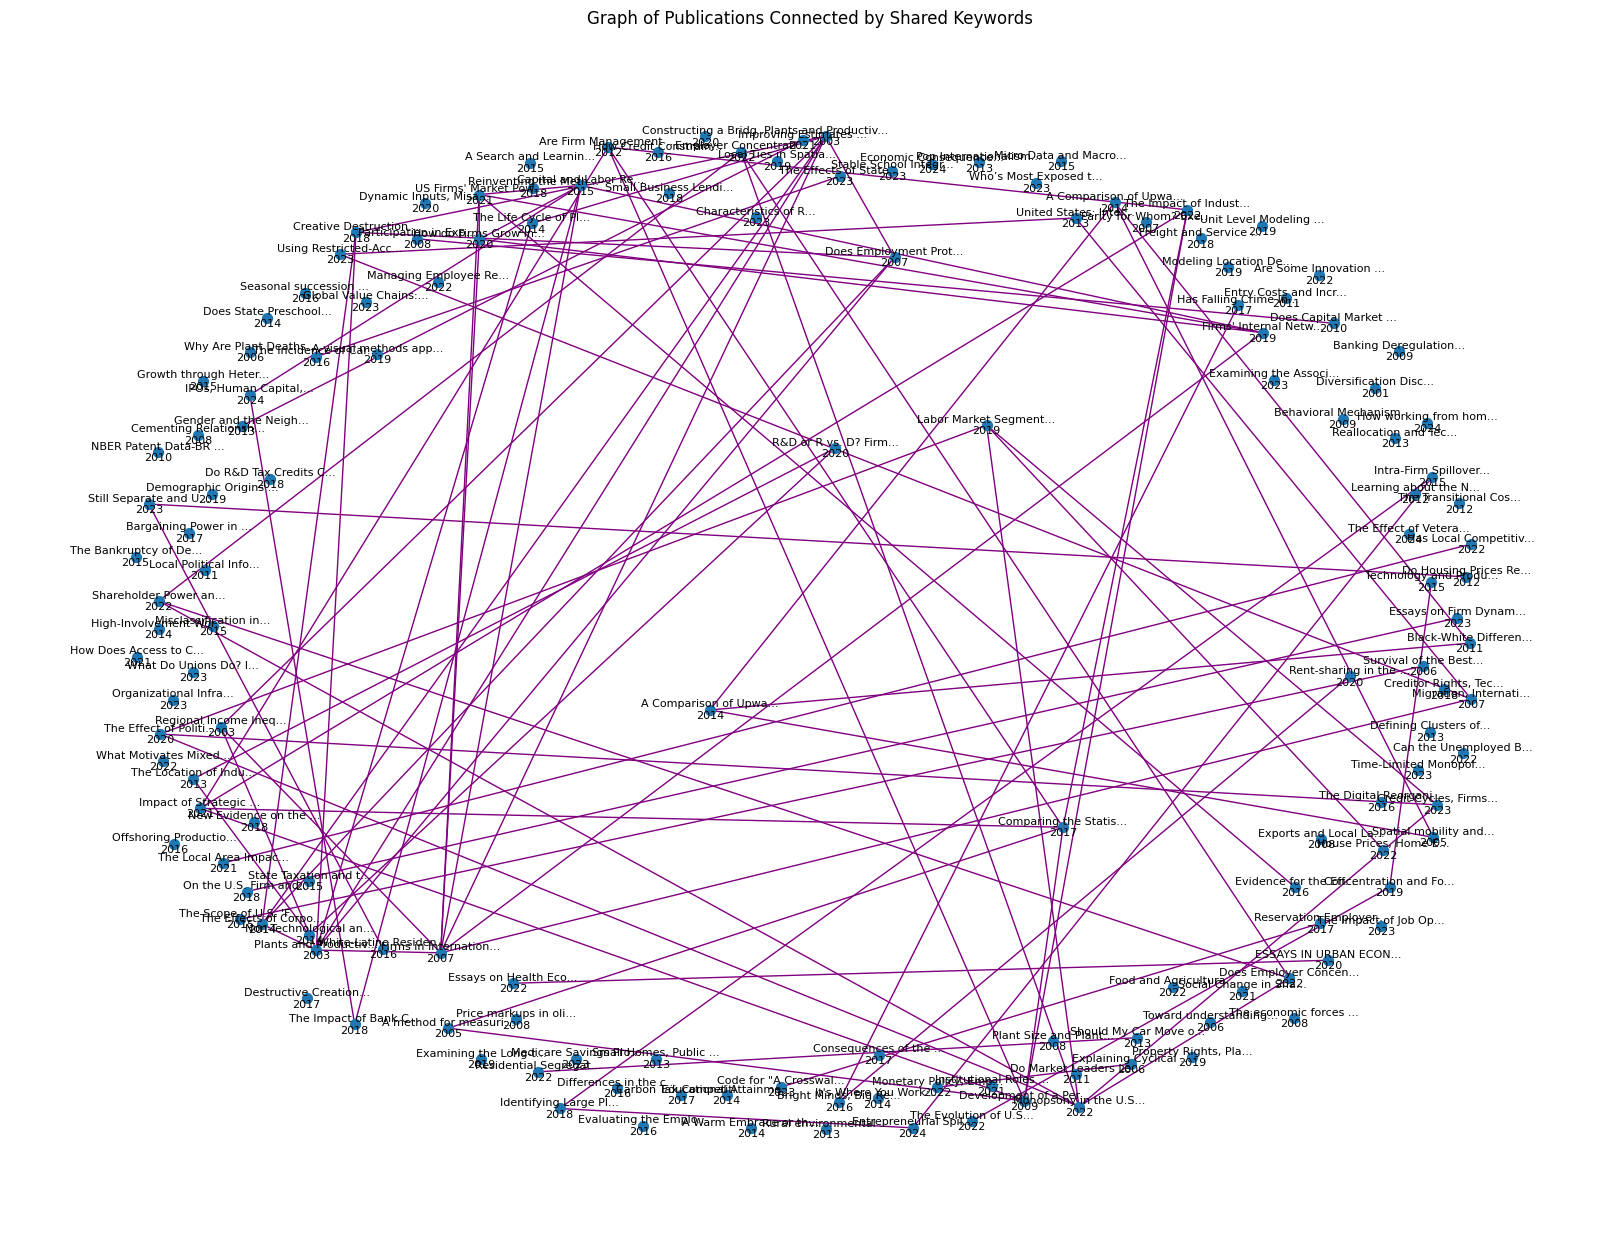

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load the dataset (assumes 'OutputTitle', 'OutputYear', 'ProjectPI', 'Keywords' exist)
df = pd.read_csv('with_keywords.csv')
df = df[['OutputTitle', 'OutputYear', 'ProjectPI', 'Keywords']].dropna()
df = df.sample(n=150, random_state=42)

# Define a class to store entries
class Publication:
    def __init__(self, title, year, author, keywords):
        self.title = str(title)
        self.year = int(year)
        self.author = str(author)
        self.keywords = [kw.strip() for kw in str(keywords).split(',')]

    def __repr__(self):
        return f"{self.title} ({self.year})"

# Convert dataframe rows to Publication objects
publications = []
for _, row in df.iterrows():
    pub = Publication(row['OutputTitle'], row['OutputYear'], row['ProjectPI'], row['Keywords'])
    publications.append(pub)

# Build the graph
G = nx.Graph()

# Add nodes
for pub in publications:
    G.add_node(pub)

# Add edges based on shared keywords
for i, pub1 in enumerate(publications):
    for pub2 in publications[i+1:]:
        if any(k in pub2.keywords for k in pub1.keywords):
            G.add_edge(pub1, pub2, color='purple')

# Draw the graph
edge_colors = nx.get_edge_attributes(G, 'color').values()
labels = {pub: f"{pub.title[:20]}...\n{pub.year}" for pub in G.nodes}
pos = nx.spring_layout(G, k=1.5)

plt.figure(figsize=(16, 12))
nx.draw(G, pos, with_labels=True, labels=labels,
        node_size=50, font_size=8, edge_color=edge_colors)
plt.title("Graph of Publications Connected by Shared Keywords")
plt.show()

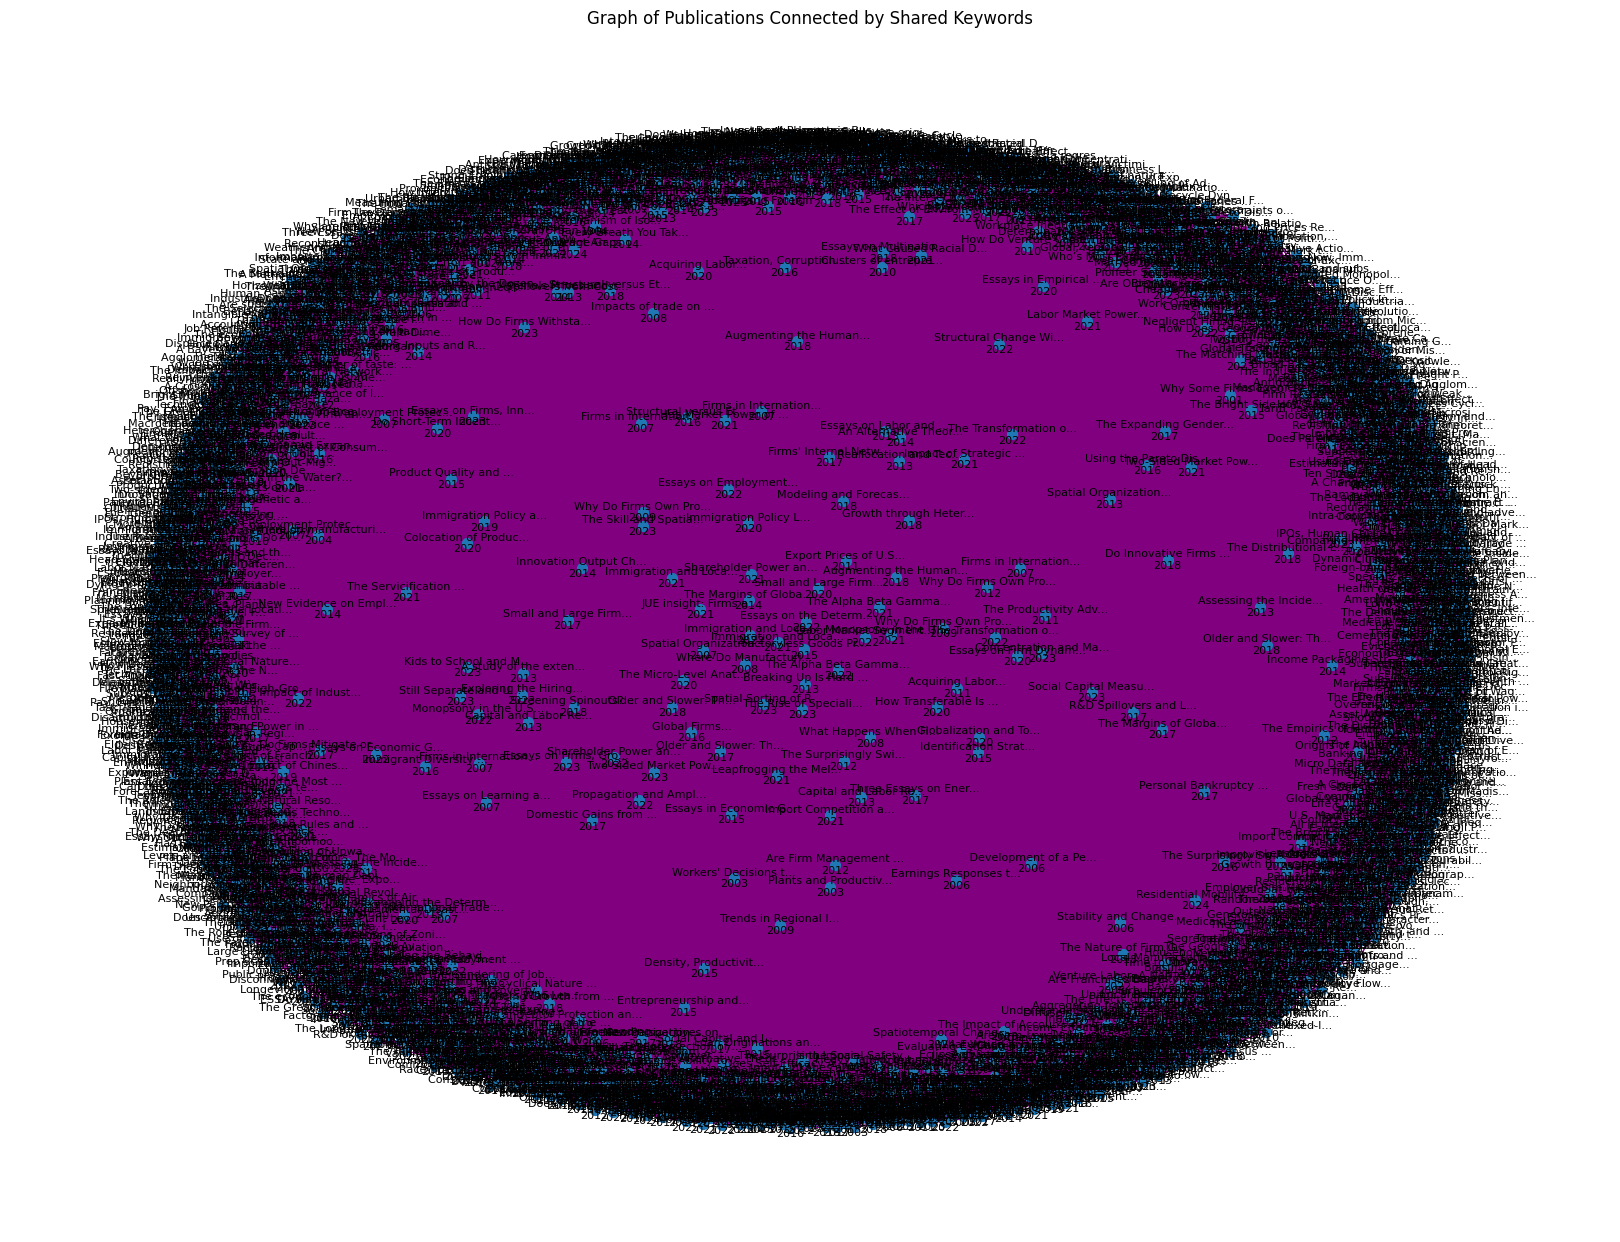

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load the dataset (assumes 'OutputTitle', 'OutputYear', 'ProjectPI', 'Keywords' exist)
df = pd.read_csv('with_keywords.csv')
df = df[['OutputTitle', 'OutputYear', 'ProjectPI', 'Keywords']].dropna()

# Define a class to store entries
class Publication:
    def __init__(self, title, year, author, keywords):
        self.title = str(title)
        self.year = int(year)
        self.author = str(author)
        self.keywords = [kw.strip() for kw in str(keywords).split(',')]

    def __repr__(self):
        return f"{self.title} ({self.year})"

# Convert dataframe rows to Publication objects
publications = []
for _, row in df.iterrows():
    pub = Publication(row['OutputTitle'], row['OutputYear'], row['ProjectPI'], row['Keywords'])
    publications.append(pub)

# Build the graph
G = nx.Graph()

# Add nodes
for pub in publications:
    G.add_node(pub)

# Add edges based on shared keywords
for i, pub1 in enumerate(publications):
    for pub2 in publications[i+1:]:
        if any(k in pub2.keywords for k in pub1.keywords):
            G.add_edge(pub1, pub2, color='purple')

# Draw the graph
edge_colors = nx.get_edge_attributes(G, 'color').values()
labels = {pub: f"{pub.title[:20]}...\n{pub.year}" for pub in G.nodes}
pos = nx.spring_layout(G, k=1.5)

plt.figure(figsize=(16, 12))
nx.draw(G, pos, with_labels=True, labels=labels,
        node_size=50, font_size=8, edge_color=edge_colors)
plt.title("Graph of Publications Connected by Shared Keywords")
plt.show()

In [ ]:
degrees = [G.degree[n] for n in G.nodes]
print(f"Average connections per publication: {sum(degrees)/len(degrees):.2f}")
print(f"Max connections: {max(degrees)}")

Average connections per publication: 18.74
Max connections: 132


# Clustering

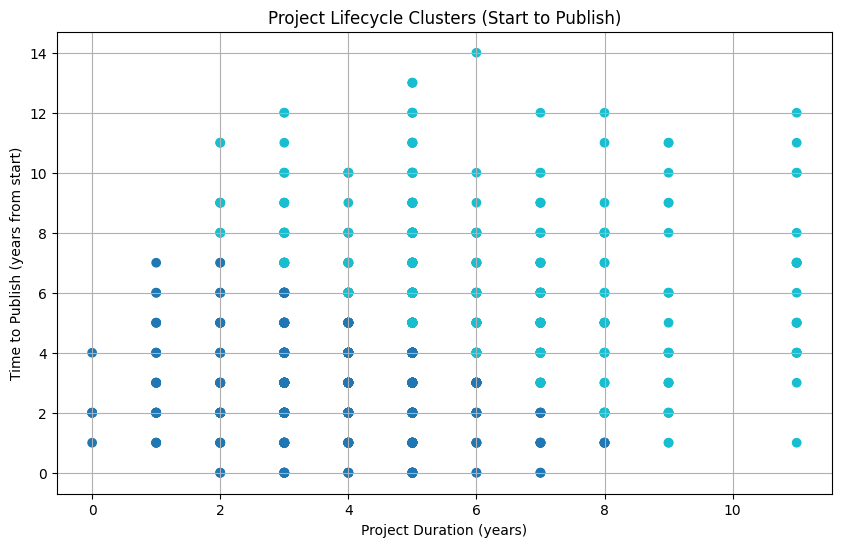

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('merged_projects_with_enrichment.csv')

# Ensure columns are numeric and drop invalid rows
cols = ['ProjectStartYear', 'ProjectEndYear', 'OutputYear']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=cols)

# Compute metrics
df['ProjectDuration'] = df['ProjectEndYear'] - df['ProjectStartYear']
df['TimeToPublishFromStart'] = df['OutputYear'] - df['ProjectStartYear']

# Filter out invalid rows
df = df[(df['ProjectDuration'] >= 0) & (df['TimeToPublishFromStart'] >= 0)].copy()

# Select features for clustering
X = df[['ProjectDuration', 'TimeToPublishFromStart']]
X_scaled = StandardScaler().fit_transform(X)

# Fit KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
df['LifecycleCluster'] = kmeans.fit_predict(X_scaled)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(df['ProjectDuration'], df['TimeToPublishFromStart'], c=df['LifecycleCluster'], cmap='tab10')
plt.xlabel('Project Duration (years)')
plt.ylabel('Time to Publish (years from start)')
plt.title('Project Lifecycle Clusters (Start to Publish)')
plt.grid(True)
plt.show()